In [1]:
import collections 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import pickle
import joblib
import skl2onnx
import onnxruntime
import lime
import lime.lime_tabular
import shap
import xgboost
from imblearn.over_sampling import RandomOverSampler

from sklearn.datasets import load_boston, load_iris
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.pipeline import make_pipeline

# Obsah
[1. Příprava dat](#1.-Příprava-dat)  
[1.1 Načtení dat](#1.1-Načtení-dat)  
[1.2 Prvotní seznámení s daty](#1.2-Prvotní-seznámení-s-daty)  
[1.3 Nahrazování NA hodnot](#1.3-Nahrazování-NA-hodnot)  
[1.4 One-hot encoding](#1.4-One-hot-encoding)  
[1.5 Train-test splitting a K-folding](#1.5-Train-test-splitting-a-K-folding)  
[1.6 Škálování](#1.6-Škálování)  
[1.7 Oversampling](#1.7-Oversampling)  
[2. Algoritmy](#2.-Algoritmy)  
[2.1 Lineární regrese](#2.1-Lineární-regrese)  
[2.2 Regresní metriky](#2.2-Regresní-metriky)  
[2.3 Ridge a lasso regrese](#2.3-Ridge-a-lasso-regrese)  
[2.4 Křížová validace (cross-validation) a GridSearch](#2.4-Křížová-validace-(cross-validation)-a-GridSearch)  
[2.5 Logistická regrese](#2.5-Logistická-regrese)  
[2.6 Metriky klasifikátorů](#2.6-Metriky-klasifikátorů)  
[2.7 Stromy](#2.7-Stromy)  
[2.8 Ensemble algoritmy obecně](#2.8-Ensemble-algoritmy-obecně)  
[2.9 Random forest](#2.9-Random-forest)  
[2.10 Gradient boosting decision tree](#2.10-Gradient-boosting-decision-tree)  
[3. Interpretovatelnost](#3.-Interpretovatelnost)  
[3.1 Partial dependence grafy](#3.1-Partial-dependence-grafy)  
[3.2 LIME](#3.2-LIME)  
[3.3 SHAP](#3.3-SHAP)  
[4. Uložení modelů a pipeliny](#4.-Uložení-modelů-a-pipeliny)  
[4.1 Ukládání](#4.1-Ukládání)  
[4.2 Pipeliny](#4.2-Pipeliny)  

# 1. Příprava dat

## 1.1 Načtení dat
Obvykle bychom data získali z nějakého csv souboru (nejspíše s pomocí funkce **pd.read_from_csv**) anebo z databáze (zde se způsoby získání různí podle typu databáze). Nicméně v rámci zjednodušení celé situace, kdy je cílem mít stejná data k dispozici, ať už tento notebook spouští kdokoli odkudkoli, využijeme data "na hraní", která jsou obsažená v balíčku sklearn. K těm se dostaneme pomocí funkcí load_XYZ, konkrétně **load_boston** a **load_iris**.  
Na následující buňce je vidět, že když chceme dostat pandí dataframe ("tabulkoidní" objekt), musíme si s výstupem load funkcí trochu pohrát. Zmíněné funkce totiž vrací slovníky, které obsahují od sebe oddělené prediktory, jména prediktorů, cílové hodnoty a popis dat.  

In [2]:
boston_data_heap = load_boston()
boston_dataframe = pd.DataFrame(boston_data_heap["data"], columns=boston_data_heap["feature_names"])
boston_dataframe["target"] = pd.Series(boston_data_heap["target"])

iris_data_heap = load_iris()
iris_dataframe = pd.DataFrame(iris_data_heap["data"], columns=iris_data_heap["feature_names"])
iris_dataframe["target"] = pd.Series(iris_data_heap["target"])

Podívejme se, co vlastně námi vyrobené dataframy obsahují. Začněme přeci jen jednodušším iris_dataframe. V něm se nalézají "provařená" data týkající se délky a šířky okvětních lístků u tří druhů kosatců (viz [wiki](https://en.wikipedia.org/wiki/Iris_flower_data_set)). Pokud si z přírodovědy pamatujete stejně málo jako já, tak sepal je ten zelený lístkoidní obal květu a petal barevný lístek květu samotného. Nula ve sloupci target znamená, že konkrétní exemplář rostliny byl iris setosa, jednička značí iris versicolor a dvojka iris verginica.  

In [3]:
iris_dataframe.sample(10)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
2                  4.7               3.2                1.3               0.2   
127                6.1               3.0                4.9               1.8   
122                7.7               2.8                6.7               2.0   
68                 6.2               2.2                4.5               1.5   
50                 7.0               3.2                4.7               1.4   
135                7.7               3.0                6.1               2.3   
23                 5.1               3.3                1.7               0.5   
113                5.7               2.5                5.0               2.0   
71                 6.1               2.8                4.0               1.3   
26                 5.0               3.4                1.6               0.4   

     target  
2         0  
127       2  
122       2  
68        1  
50        1  
135       2  
23        0  
113       2  
71        1  
26        0

DataFrame boston_dataframe obsahuje již pár desetiletí neaktuální ceny nemovitostí na předměstích Bostonu. Význam jednotlivých sloupců je následující:  
- CRIM: per capita crime rate by town  
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.  
- INDUS: proportion of non-retail business acres per town  
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)  
- NOX: nitric oxides concentration (parts per 10 million)  
- RM: average number of rooms per dwelling  
- AGE: proportion of owner-occupied units built prior to 1940  
- DIS: weighted distances to five Boston employment centres  
- RAD: index of accessibility to radial highways  
- TAX: full-value property-tax rate per \$10,000  
- PTRATIO: pupil-teacher ratio by town  
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  
- LSTAT: \% lower status of the population  
- target: Median value of owner-occupied homes in \$1000's  


In [4]:
boston_dataframe.sample(10)

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
190   0.09068  45.0   3.44   0.0  0.437  6.951   21.5  6.4798   5.0  398.0   
412  18.81100   0.0  18.10   0.0  0.597  4.628  100.0  1.5539  24.0  666.0   
180   0.06588   0.0   2.46   0.0  0.488  7.765   83.3  2.7410   3.0  193.0   
111   0.10084   0.0  10.01   0.0  0.547  6.715   81.6  2.6775   6.0  432.0   
208   0.13587   0.0  10.59   1.0  0.489  6.064   59.1  4.2392   4.0  277.0   
105   0.13262   0.0   8.56   0.0  0.520  5.851   96.7  2.1069   5.0  384.0   
461   3.69311   0.0  18.10   0.0  0.713  6.376   88.4  2.5671  24.0  666.0   
143   4.09740   0.0  19.58   0.0  0.871  5.468  100.0  1.4118   5.0  403.0   
495   0.17899   0.0   9.69   0.0  0.585  5.670   28.8  2.7986   6.0  391.0   
12    0.09378  12.5   7.87   0.0  0.524  5.889   39.0  5.4509   5.0  311.0   

     PTRATIO       B  LSTAT  target  
190     15.2  377.68   5.10    37.0  
412     20.2   28.79  34.37    17.9  
180     17.8  395.56   7.56    39.8  
111     17.8  395.59  10.16    22.8  
208     18.6  381.32  14.66    24.4  
105     20.9  394.05  16.47    19.5  
461     20.2  391.43  14.65    17.7  
143     14.7  396.90  26.42    15.6  
495     19.2  393.29  17.60    23.1  
12      15.2  390.50  15.71    21.7

## 1.2 Prvotní seznámení s daty

Než budeme s daty jakkoli manipulovat, bylo by dobré si je prohlédnout. Jednak kvůli zjištění jejich kvality (např. jde o počet null hodnot), jednak proto, abychom lépe porozuměli jednotlivým prediktorům. Pro takovéto operace je velmi užitečný balíček [pandas-profiling](https://github.com/pandas-profiling/pandas-profiling). Jelikož by jeho použití zčtyřnásobilo velikost notebooku, kód zde spuštěn není, spustit si ho musíte u sebe

```python
from pandas_profiling import ProfileReport

profile = ProfileReport(boston_dataframe, title="Boston profile")
profile
```

Nicméně zkusme zde ony kontrolní operace udělat i ručně ručně. Problém s pandas-profiling reportem je totiž v tom, že jeho vyrábění je dosti náročné na RAMku a občas ho na dýchavičných strojích zkrátka nebudeme moci použít. 

Funkce **info** nám ukazuje, že ani v jednom datasetu není žádná NULL hodnota. Dokonce zde není ani žádná kategorická veličina uložená jako string, na kterou bychom museli vypustit one-hot encoding (de facto převod stringové hodnoty na několik sloupců typu integer). Nicméně vzhledem k nutnosti ošetření těchto situací, které u normálních neučesaných dat takřka vždy vzniknou, se těmto problémum budeme zakrátku věnovat na falešných datech.

In [5]:
iris_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [6]:
boston_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Interpretace čísel u tabulky kosatců je krystalicky jasná. Nejprve si uděláme shrnující statistiky. Jelikož se nám zde ale dohromady slévá více tříd (více typů kytek), nemá cenu příliš bádat nad průměrnou hodnotou prediktorů. Nicméně užitečné je zkontrolovat, jak si stojí průměr/medián vzhledem k maximu a minimu a zda ona maxima/minima nejsou ulítlá. To by znamenalo přítomnost outlieru a potřebu s ním nějak pracovat (třeba záznam s ním vyhodit, pakliže byl outlier způsoben překlepem při zápisu parametrů rostliny).  

In [7]:
iris_dataframe.describe()

sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000

Užitečné je v tomto kontextu podívat se na statistiky pro jednotlivé třídy. Například z tabulky níže vidíme, že se kosatec typu 0 jasně odlišuje od zbylých dvou druhů, které mají parametry vzájemně mnohem podobnější.

In [8]:
iris_dataframe.groupby("target").agg(
    sepal_length_mean=("sepal length (cm)", np.mean),
    sepal_length_std=("sepal length (cm)", np.std),
    sepal_width_mean=("sepal width (cm)", np.mean),
    sepal_width_std=("sepal width (cm)", np.std),
    petal_length_mean=("petal length (cm)", np.mean),
    petal_length_std=("petal length (cm)", np.std),        
    petal_width_mean=("petal width (cm)", np.mean),
    petal_width_std=("petal width (cm)", np.std),
)

sepal_length_mean  sepal_length_std  sepal_width_mean  \
target                                                          
0                   5.006          0.352490             3.428   
1                   5.936          0.516171             2.770   
2                   6.588          0.635880             2.974   

        sepal_width_std  petal_length_mean  petal_length_std  \
target                                                         
0              0.379064              1.462          0.173664   
1              0.313798              4.260          0.469911   
2              0.322497              5.552          0.551895   

        petal_width_mean  petal_width_std  
target                                     
0                  0.246         0.105386  
1                  1.326         0.197753  
2                  2.026         0.274650

Nicméně asi lepší bude vizualizace (pro úsporu místa tu ukazujeme pouze graf prvního z prediktorů).

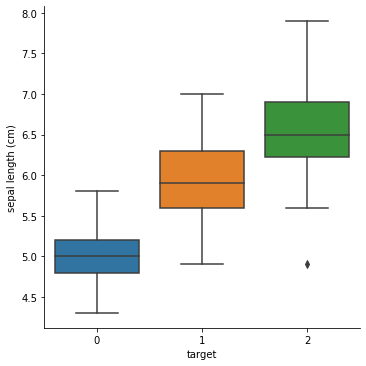

In [9]:
sns.catplot(x="target", y="sepal length (cm)", data=iris_dataframe, kind="box")

Prozkoumejme ale nyní data nemovitostí.  
Nejprve se podíváme na základní statistiky. Jelikož se v cílovém sloupci nevyskytují kategorie, ale spojité hodnoty, nemá smysl se pokoušet o grupování.

In [10]:
boston_dataframe.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT      target  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

Pro vizualizaci závislosti prediktoru na cílové hodnotě bude v tomto případě lepší než boxplot scatterplot. Například u kriminality vidíme, že se s jejím růstem pojí pokles cen. Samozřejmě to může znamenat jak to, že oblasti s velkou mírou kriminality nejsou na realitním trhu příliš atraktivní, anebo to, že se do levných lokalit stěhují lidé, kteří mají problémy se zákonem, anebo možná existuje nějaká třetí okolnost, od které jsou odvislé jak kriminalita, tak nízká cena.

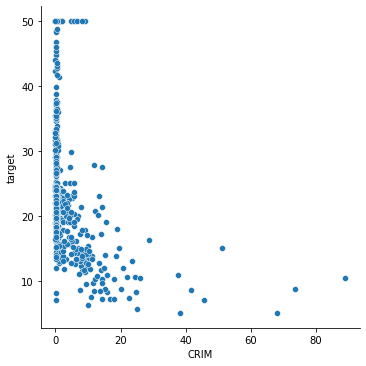

In [11]:
sns.relplot(x="CRIM", y="target", data=boston_dataframe, kind="scatter")

Jinými slovy "korelace není kauzaliza". Nicméně když se tu už o korelaci bavíme, bývá užitečné si ji taktéž spočítat. Obecně by bylo ideální, kdyby každý prediktor koreloval s cílovým sloupcem co možná nejvíce, ale kdyby současně mezi sebou jednotlivé prediktory nekorelovaly. Když tomu tak totiž není, mohou některé algoritmy podávat horší výkon. Řešením tohoto problému může být např. PCA (principal component analysis) neboli přetvoření většího počtu částečně korelovaných prediktorů v menší počet prediktorů nekorelovaných. Nepříjemná však poté bývá skutečnost, že nové prediktory nejsou z byznysového hlediska dost dobře interpretovatelné.  
Zdůrazněme nakonec, že tu celou dobu budeme mít na mysli korelaci lineární.

In [12]:
boston_dataframe.corr()

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 -0.356977  0.048788 -0.380051  0.128069 -0.273534   
LSTAT    0.455621 -0.412995  0.603800 -0.053929  0.590879 -0.613808  0.602339   
target  -0.388305  0.360445 -0.483725  0.175260 -0.427321  0.695360 -0.376955   

              DIS       RAD       TAX   PTRATIO         B     LSTAT    target  
CRIM    -0.379670  0.625505  0.582764  0.289946 -0.385064  0.455621 -0.388305  
ZN       0.664408 -0.311948 -0.314563 -0.391679  0.175520 -0.412995  0.360445  
INDUS   -0.708027  0.595129  0.720760  0.383248 -0.356977  0.603800 -0.483725  
CHAS    -0.099176 -0.007368 -0.035587 -0.121515  0.048788 -0.053929  0.175260  
NOX     -0.769230  0.611441  0.668023  0.188933 -0.380051  0.590879 -0.427321  
RM       0.205246 -0.209847 -0.292048 -0.355501  0.128069 -0.613808  0.695360  
AGE     -0.747881  0.456022  0.506456  0.261515 -0.273534  0.602339 -0.376955  
DIS      1.000000 -0.494588 -0.534432 -0.232471  0.291512 -0.496996  0.249929  
RAD     -0.494588  1.000000  0.910228  0.464741 -0.444413  0.488676 -0.381626  
TAX     -0.534432  0.910228  1.000000  0.460853 -0.441808  0.543993 -0.468536  
PTRATIO -0.232471  0.464741  0.460853  1.000000 -0.177383  0.374044 -0.507787  
B        0.291512 -0.444413 -0.441808 -0.177383  1.000000 -0.366087  0.333461  
LSTAT   -0.496996  0.488676  0.543993  0.374044 -0.366087  1.000000 -0.737663  
target   0.249929 -0.381626 -0.468536 -0.507787  0.333461 -0.737663  1.000000

Většina prediktorů vypadá dle popisu lineárně anebo se jedná o prediktory binární (tj. nabývající pouze hodnot 0 a 1). Výjimkou je veličina B, která poněkud netriviálně závisí na populaci afroameričanů v daném předměstí.

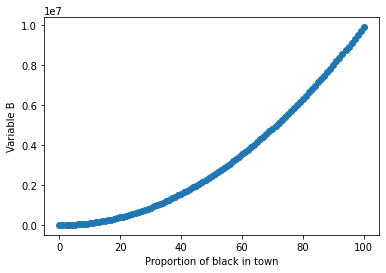

In [13]:
x_axis = list(range(0,101))
y_axis = [(1000*(x - 0.63)*(x - 0.63)) for x in x_axis]
plt.scatter(x_axis, y_axis)
plt.xlabel("Proportion of black in town")
plt.ylabel("Variable B");

## 1.3 Nahrazování NA hodnot
Jak již bylo řečeno, v datech žádné díry (NA/NaN/nully) nemáme. Co bychom ale měli udělat, když by se tam nacházely? Asi nejjednodušším řešením je takové záznamy vyhodit. To si ale můžeme dovolit pouze v případě, kdy je jich relativně málo a jsme si jistí, že se jedná o důsledek nějaké nesystematické chyby (např. nepozornost při přepisu dat z papírů do počítače).   
Vyhazování se realizuje funkcí **pandas.dropna**. Parametrem **axis** specifikujeme, zda se budou vyhazovat řádky(0) či sloupce (1) NaN obsahující. Parametr **how** říká, zda k vyhození stačí jedna v řádku/sloupci absentující hodnota ("any") či zda musí absentovat hodnoty všechny("all").

In [14]:
emental_dataframe = pd.DataFrame([
                        [np.nan, 2, np.nan, 0],
                        [3, 4, np.nan, 1],
                        [np.nan, np.nan, np.nan, 5],
                        [np.nan, 3, np.nan, 4],
                        [1, 3, 2, 4],
                        ],
                        columns=list('ABCD'))
emental_dataframe

A    B    C  D
0  NaN  2.0  NaN  0
1  3.0  4.0  NaN  1
2  NaN  NaN  NaN  5
3  NaN  3.0  NaN  4
4  1.0  3.0  2.0  4

In [15]:
emental_dataframe.dropna(axis=0, how="any")

A    B    C  D
4  1.0  3.0  2.0  4

V některých případech víme, že null hodnota businessově znamená číslo nula. Jindy se zase jedná o překlep a tudíž by se na ono místo měla vložit průměrná hodnota sloupce. K tomu slouží funkce **pandas.fillna**. Ta opět potřebuje specifikovat, zda chceme doplňovat prázdná pole podle sloupců či řádků (parametr *axis*). Dále této funkci musíme specifikovat i samotnou doplňovanou hodnotu.

In [16]:
emental_dataframe["A"] = emental_dataframe[["A"]].fillna(
    axis=1,
    value=np.mean(emental_dataframe["A"])
)
emental_dataframe

A    B    C  D
0  2.0  2.0  NaN  0
1  3.0  4.0  NaN  1
2  2.0  NaN  NaN  5
3  2.0  3.0  NaN  4
4  1.0  3.0  2.0  4

Existují ale i sofistikovanější způsoby, jak nully nahradit - tzv. imputery. Ty se pravda primárně využívají v pipelinách (viz konec výkladu). Jak s nimi zacházet? Podívejme se na nejddednodušší z nich - simple imputer. V jeho konstruktoru zadefinujeme s pomocí parametru **strategy**, jak vlastně bude nully nahrazovat. U numerických sloupců mu můžeme přikázat, aby prázdné hodnoty nahradil průměrem či mediánem zbylých hodnot ve sloupci (**strategy="mean"**, resp. **strategy="median**). Jak u sloupců numerických, tak u sloupců s textovými řetězci dostaneme pomocí **strategy="most_frequent"** na místo null hodnoty hodnotu ve sloupci nejčastější. A pokud chceme na onom místě mít ručně specifikovanou hodnotu, vložíme do **strategy** parametru hodnotu **constant** a do kontrukturu SimpleImputeru přidáme parametr **fill_value="hodnota"**. 

In [17]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy="median")
median_imputer.fit_transform(emental_dataframe)

array([[2., 2., 2., 0.],
       [3., 4., 2., 1.],
       [2., 3., 2., 5.],
       [2., 3., 2., 4.],
       [1., 3., 2., 4.]])

In [18]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy="constant", fill_value=999)
median_imputer.fit_transform(emental_dataframe)

array([[  2.,   2., 999.,   0.],
       [  3.,   4., 999.,   1.],
       [  2., 999., 999.,   5.],
       [  2.,   3., 999.,   4.],
       [  1.,   3.,   2.,   4.]])

## 1.4 One-hot encoding
One-hot encoding znamená převod jednoho sloupce obsahující N kategorií (nejčastěji stringů) na N sloupců s hodnotami 0 či 1. Zde flag 1 znamená, že ten který záznam do příslušné kategorie patří.  
Demonstrovat one-hot encoding budeme na pro ten účel vzniklé kopii kosatcového dataframu. Tu si vytvoříme pomocí metody **copy** navázané na zmíněný dataframe. Zdůrazněme, že tímto způsobem získáme deep a ne shallow kopii. To znamená, že opravdu vzniká nový dataframe a nikoli jen nová reference na stejná podkladová data. V následujícím kroku totiž budeme dataframe upravovat a nechceme, aby se změny propsaly do originální tabulky.  
Představme si, že by sloupec target nebyl sloupcem cílovým, nýbrž by se jednalo pouze o jeden z řady prediktorů. V takovém případě bychom tento kategorický sloupec museli převést na trojici sloupců říkajících, zda je daný exemplář rostliny typu setosa, versicolor či verginica. Aby byla situace ještě názornější, změníme napřed hodnoty v target sloupci z čísla na odpovídající textový řetězec a to sice s použitím **loc**.  
Zdůrazněme, že u cílového sloupce takováto operace nedává žádný smysl. U něj se očekává, že v něm budou integery zastupujícící všechny třídy. Dokonce by zde ani nevadilo, kdyby třídy byly vyjádřeny stringy - ML algoritmy z sklearnu by se s tím měly popasovat.

In [19]:
encoding_iris = iris_dataframe.copy()
encoding_iris.loc[encoding_iris["target"]==0, "target"] = "iris setosa"
encoding_iris.loc[encoding_iris["target"]==1, "target"] = "iris versicolor"
encoding_iris.loc[encoding_iris["target"]==2, "target"] = "iris verginica"
encoding_iris.sample(10)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
34                4.9               3.1                1.5               0.2   
14                5.8               4.0                1.2               0.2   
17                5.1               3.5                1.4               0.3   
53                5.5               2.3                4.0               1.3   
57                4.9               2.4                3.3               1.0   
9                 4.9               3.1                1.5               0.1   
97                6.2               2.9                4.3               1.3   
37                4.9               3.6                1.4               0.1   
3                 4.6               3.1                1.5               0.2   
86                6.7               3.1                4.7               1.5   

             target  
34      iris setosa  
14      iris setosa  
17      iris setosa  
53  iris versicolor  
57  iris versicolor  
9       iris setosa  
97  iris versicolor  
37      iris setosa  
3       iris setosa  
86  iris versicolor

Jak tedy převod jednoho sloupce stringového na tři sloupce binární provedeme? Nejprve si vytvoříme one-hot encoderovský objekt. U něho posléze zavoláme jeho metodu **fit_transform**. Té jako parametr předáme sloupec původní tabulky, na němž chceme one-hot encoding provést. Nakonec je třeba tabulku původní a nové sloupce na sebe nalepit. To provedeme pomocí funkce **pandas.concat**. Tato funkce  zde pravda vypadá trochu strašidelně. Dostává dva parametry - prvním je list na sebe lepených dataframů, druhým je **axis** říkající, zda se ony dataframy budou lepit jeden pod druhý (tj. přibudou řádky), anebo jeden vedle druhého (tj. přibudou sloupce). My chceme pro stejný počet řádků mít více sloupců, volíme tudíž hodnotu parametru **axis** rovnou jedné.  
Nicméně abychom mohli produkt one-hot encoderu vložit do listu dataframů, musíme z něj dataframe napřed udělat. Výstupem funkce **fit_transform** je totiž pouze **numpy.array**. Jeho převod je naštěstí jednoduchý - stačí ho vložit do konstruktoru pandího dataframu. Do tohoto konstruktoru navíc vložíme i jména nových sloupců, které encoder též poskytuje.  

In [20]:
from sklearn.preprocessing import OneHotEncoder

normal_encoder = OneHotEncoder()
transformed_flower_name = normal_encoder.fit_transform(encoding_iris[["target"]])
whole_table = pd.concat(
    [
        encoding_iris, 
        pd.DataFrame(
            transformed_flower_name.toarray(), 
            columns=normal_encoder.get_feature_names().tolist()
        )
    ], 
    axis=1
)
whole_table.sample(10)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
128                6.4               2.8                5.6               2.1   
108                6.7               2.5                5.8               1.8   
78                 6.0               2.9                4.5               1.5   
140                6.7               3.1                5.6               2.4   
145                6.7               3.0                5.2               2.3   
83                 6.0               2.7                5.1               1.6   
45                 4.8               3.0                1.4               0.3   
27                 5.2               3.5                1.5               0.2   
139                6.9               3.1                5.4               2.1   
142                5.8               2.7                5.1               1.9   

              target  x0_iris setosa  x0_iris verginica  x0_iris versicolor  
128   iris verginica             0.0                1.0                 0.0  
108   iris verginica             0.0                1.0                 0.0  
78   iris versicolor             0.0                0.0                 1.0  
140   iris verginica             0.0                1.0                 0.0  
145   iris verginica             0.0                1.0                 0.0  
83   iris versicolor             0.0                0.0                 1.0  
45       iris setosa             1.0                0.0                 0.0  
27       iris setosa             1.0                0.0                 0.0  
139   iris verginica             0.0                1.0                 0.0  
142   iris verginica             0.0                1.0                 0.0

Všimněme si jmen nových sloupců. V jejich druhé části je jméno kategorie, část první se ale skládá z nejasného "x0". Co musíme udělat, když chceme "x0", "x1" atd. nahradit za jména původních encodovaných sloupců? V takovém případě je třeba do funkce **get_feature_name** vložit seznam sloupců encodovaného dataframu:

In [21]:
normal_encoder = OneHotEncoder()
transformed_flower_name = normal_encoder.fit_transform(encoding_iris[["target"]])
whole_table = pd.concat(
    [
        encoding_iris, 
        pd.DataFrame(
            transformed_flower_name.toarray(), 
            columns=normal_encoder.get_feature_names(encoding_iris[["target"]].columns).tolist()
        )
    ], 
    axis=1
)
whole_table.sample(10)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
24                 4.8               3.4                1.9               0.2   
42                 4.4               3.2                1.3               0.2   
143                6.8               3.2                5.9               2.3   
76                 6.8               2.8                4.8               1.4   
35                 5.0               3.2                1.2               0.2   
141                6.9               3.1                5.1               2.3   
68                 6.2               2.2                4.5               1.5   
59                 5.2               2.7                3.9               1.4   
99                 5.7               2.8                4.1               1.3   
87                 6.3               2.3                4.4               1.3   

              target  target_iris setosa  target_iris verginica  \
24       iris setosa                 1.0                    0.0   
42       iris setosa                 1.0                    0.0   
143   iris verginica                 0.0                    1.0   
76   iris versicolor                 0.0                    0.0   
35       iris setosa                 1.0                    0.0   
141   iris verginica                 0.0                    1.0   
68   iris versicolor                 0.0                    0.0   
59   iris versicolor                 0.0                    0.0   
99   iris versicolor                 0.0                    0.0   
87   iris versicolor                 0.0                    0.0   

     target_iris versicolor  
24                      0.0  
42                      0.0  
143                     0.0  
76                      1.0  
35                      0.0  
141                     0.0  
68                      1.0  
59                      1.0  
99                      1.0  
87                      1.0

Zamysleme se ještě nad výstupem encoderu. Z tabulky vidíme, že jeden ze tří sloupců s jedničkami a nulami je zbytečný. Jakmile totiž známe hodnoty ve dvou sloupcích, snadnou úvahou dojdeme i k hodnotám ve sloupci třetím. Ještě markantnější by to bylo v případě, kdy by byl původní encodovaný sloupec binární. Zdůrazněme, že toto není pouze problém estetický, ale i praktický - některé algoritmy, například lineární regrese bez regularizace, by s takovýmito daty měly problém.  
Jak takovouto situaci ošetřit? Do konstruktoru encoderu vložíme parametr **drop** s hodnotou buďto **first** anebo **if_binary**. "first" vyhodí první kategorii (a to i pokud je ve sloupci jen jedna kategorie), "if_binary" proveden takovéto vyhazování pouze pokud jsou ve zdrojovém sloupci dvě kategorie.

In [22]:
normal_encoder = OneHotEncoder(drop="first")
transformed_flower_name = normal_encoder.fit_transform(encoding_iris[["target"]])
whole_table = pd.concat(
    [
        encoding_iris, 
        pd.DataFrame(
            transformed_flower_name.toarray(), 
            columns=normal_encoder.get_feature_names().tolist()
        )
    ], 
    axis=1
)
whole_table.sample(10)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
79                 5.7               2.6                3.5               1.0   
61                 5.9               3.0                4.2               1.5   
106                4.9               2.5                4.5               1.7   
15                 5.7               4.4                1.5               0.4   
34                 4.9               3.1                1.5               0.2   
81                 5.5               2.4                3.7               1.0   
13                 4.3               3.0                1.1               0.1   
131                7.9               3.8                6.4               2.0   
135                7.7               3.0                6.1               2.3   
33                 5.5               4.2                1.4               0.2   

              target  x0_iris verginica  x0_iris versicolor  
79   iris versicolor                0.0                 1.0  
61   iris versicolor                0.0                 1.0  
106   iris verginica                1.0                 0.0  
15       iris setosa                0.0                 0.0  
34       iris setosa                0.0                 0.0  
81   iris versicolor                0.0                 1.0  
13       iris setosa                0.0                 0.0  
131   iris verginica                1.0                 0.0  
135   iris verginica                1.0                 0.0  
33       iris setosa                0.0                 0.0

Hodnotami v encodovaném sloupci mohou být čísla či stringy, ne však None. Tudíž následující kód by skončil chybou:
```python
encoding_iris.loc[0,"target"] = None

normal_encoder = OneHotEncoder()
transformed_flower_name = normal_encoder.fit_transform(encoding_iris[["target"]])
```

Poznámka závěrem - ve starších verzích sklearnu (tuším před verzí 0.20) požadoval OneHotEncoder na vstupu sloupec s integery. Když měl člověk sloupec se stringy, musel je předtím převést na čísla pomocí LabelEncoderu. Nyní už to naštěstí není potřeba, nicméně člověk by na to měl myslet, když pracuje se zastaralými verzemi balíčků.

A nakonec ještě jedna poznámka, snad už opravdu poslední. Na první pohled stejného výsledku by se dalo dosáhnout i pomocí pandasí funkce **get_dummies**. One-hot encoder má ale tu výhodu, že přetrvá i po prvním použití a dá se použít na transformaci dalších dat. Uvažme situaci, kdy bychom natrénovali model, od něhož bychom očekávali online predikci, kdy na jeho vstup dorazí v jeden okamžik jen jeden záznam. V takovém případě **get_dummies** nemůže vědět, jak má kategorii zpracovat, zatímco encoder si postup zpracování bude pamatovat ze svého fitování.

## 1.5 Train-test splitting a K-folding
Dejme tomu, že máme připravený dataframe a chceme na něj vypustit nějaký machine-learningový algoritmus. Abychom mohli posoudit, zda onen algoritmus pracuje správně, vyčleníme z dat několik náhodně vybraných záznamů - obvykle 20% či 10%. O této menší části dat hovoříme jako o testovací množině dat, zatímco zbytek spadá do množiny trénovací. S její pomocí natrénujeme ML model. Posléze vezmeme prediktory z vyčleněných záznamů, model předpoví targety a ty nějak porovnáme se skutečným target sloupcem testovací množiny.  
Nyní vyvstává otázka, jak vlastně rozdělit data na trénovací a testovací. Nejjednoduššeji to jde s metodou **train_test_split**. Ta dostává na vstup sekvenci listů či pandích dataframů/sérií. Ty musí mít stejný počet prvků - to v případě kombinace listu a dataframu znamená, že počet prvků listu se musí rovnat počtu řádku dataframu. Další parametr - test_size - udává procentuální zastoupení testovací množiny. Funkce každý vstupní element rozdělí na dva právě podle tohoto čísla. Zdůrazněme, že datový typ je zachován, tj. z dataframu vzniknou dataframy, ze serie série, z listu listy. Parametr random_state tu máme proto, aby funkce vracela stejný výsledek jam mě při psaní těchto řádků, tak Vám, až u sebe budete tento kód zkoušet.

In [23]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)
print(f"Shape of original dataframe: {iris_dataframe.shape}")
print(f"Shape of train_features: {train_features.shape}")
print(f"Shape of test_features: {test_features.shape}")
print(f"Shape of train_target: {train_target.shape}")
print(f"Shape of test_target: {test_target.shape}")

Shape of original dataframe: (150, 5)
Shape of train_features: (120, 4)
Shape of test_features: (30, 4)
Shape of train_target: (120,)
Shape of test_target: (30,)


Jak je vidno z indexu dataframu, funkce **train_test_split** provádí náhodné rozdělení defaultně.

In [24]:
train_features.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
58                 6.6               2.9                4.6               1.3
97                 6.2               2.9                4.3               1.3
129                7.2               3.0                5.8               1.6
114                5.8               2.8                5.1               2.4
146                6.3               2.5                5.0               1.9

Občas pouhopouhé rozdělení dat na trénovací a testovací nestačí. Některé algoritmy totiž nemají jen parametry, jejichž hodnoty model určí při trénování, ale i tzv. hyperparametry, které musí být stanoveny coby vstup algoritmu. Typické je to u "ensamble" algoritmů, jenž se skládají z hromady jednoduchých ML algoritmů, které o výsledné predikci pro ten který konkrétní záznam hlasují. Jedním z hyperparametrů takovýchto algoritmů je právě počet hlasujících. Pokud bychom zůstali v train-test modu, ladili bychom ony hyperparametry podle testovací množiny. Tato testovací množina by poté neměla význam pro konečné stanovení přenosti modelu, neboť jsme ji použili při samotném trénování modelu.  
Co se tedy musí udělat? Původní data se rozdělí na trénovací a testovací. Trénovací data čeká ale další dělení na "subtrénovací" a validační množinu. Měníme hyperparametry, trénujeme model na subtrénovací množině a jeho prediktivní sílu určujeme jeho aplikací na validační množinu. Když jsme spokojeni (myšleno našli jsme optimální hodnotu hyperparametrů), natrénujeme model ještě jednou - tentokrát jsou trénovacími daty opravdu celá trénovací data (tj. subtrénovací i validační množina dohromady). Prediktivní síla získaná použitím modelu na testovací množinu se pak už může porovnávat s modely ostatními.  
Problém tohoto postupu tkví ve skutečnosti, že subtrénovací množina i množina validační jsou poměrně malé. Roste tak vliv outlierů. Proto natrénování modelu na jedné validační množině nestačí - co kdyby byl právě v oné validační množině outlier, který zkazí statistiky optimálního modelu? Řešením je aplikace k-foldingu. Tehdy je prvotní trénovací množina rozdělena na k (nejčastěji k=10 či k=5) stejně velkých částí. Z nichž pro k=10 první až devátá část vytvoří subtrénovací množinu, desátá část validační množinu. Na těchto datech se natrénuje model a získají se jeho statistiky. Posléze se na zformování subtrénovací množiny vezmou druhá až desátá část, validační množinu tvoří část první. Opět následuje trénování modelu a sběr statistik. Během deseti iterací se části prostřídají, tj. každá jednou funguje jako validační množina. Výsledná statistika pro konkrétní hyperparametr se pak vezme jako průměr deseti statistik z oněch proběhlých deseti iterací.  
Jak s k-foldingem prakticky pracovat? Nejprve se musí vytvořit instace **KFold** objektu. Do konstruktoru se vloží počet částí, na které se vstupní data rozdělí (parametr **n_splits**), a to, zda chceme, aby byly záznamy do jednotlivých částí vloženy náhodně (**shuffle=True**) anebo popořadě (**shuffle=False**).  

In [25]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=10, shuffle=True, random_state=10)

Samotná instance nic moc nedělá. Musí se zavolat funkce **split**. Ta na základě dataframu, který se jí předá jako parametr, vytvoří posloupnosti indexů pro subtrénovací a validační množinu:

In [26]:
for train_indices, test_indices in k_fold.split(iris_dataframe):
    print(train_indices, test_indices)

[  0   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  40  41  42  43  44  45  46  47  48  50  51  52  54  56  57  58  59  61
  62  63  64  65  68  69  70  71  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  88  89  90  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 143 144 145 146 147 148 149] [  1  10  19  39  49  53  55  60  66  67  72  87  91 111 142]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  25  26  27  28  29  30  31  32  33  34  36  37  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  77  78
  79  80  81  82  83  84  86  87  88  89  91  92  93  94  96  97  98  99
 100 101 103 104 105 106

Při faktickém použití by se pak tyto indexy v rámci for smyčky použily k vydělení záznamů z train dat vytvořených pomocí train_test_splitu:
```python
for train_indices, test_indices in k_fold.split(iris_dataframe):
    subtrain_train_features = train_features.iloc[train_indices]
    subtrain_test_features = train_features.iloc[test_indices]
    subtrain_train_target = train_target.iloc[train_indices]
    subtrain_test_target = train_target.iloc[test_indices]
    #ML algorithm
```

Naštěstí to celé lze realizovat i snadněji s pomocí **GridSearchCV**. To si ale povíme až níže u konkrétních algoritmů.

## 1.6 Škálování
Představme si dataframe, ve kterém se nacházejí dva predikční sloupce. V jednom je váha v kilogramech, v druhém délka v metrech. Existují algoritmy, pro které vstupní data v takovémto formátu nepředstavují problém (zejména se jedná o stromy a lesy). Většina algoritmů (neuronové sítě, K-means, ale třeba i regularizovaná lineární regrese) s tím ale potíže mít bude. Pokud bychom například v prediktorech měli výšku a váhu člověka, jak by mohl chudák počítač vědět, jestli si jsou podobnější záznamy o stejné výšce a váze lišící se o 1 kg, anebo záznamy o stejné váze a výšce lišící se o 1 m? A co kdyby výška nebyla v metrech, nýbrž třeba centimetrech? Proto se obvykle data škálují. Tím se nejčastěji myslí, že se hodnoty v jednom sloupci přepočítají tak, aby průměr hodnot ve sloupci činil nulu a standardní odchylka byla rovná jedné. Díky tomu už budou hodnoty v sloupcích zastupujících odlišné věci provnatelné.  
Zmiňme, že v některých případech škálování není doporučované. Jde zejména o binární sloupce, tj. sloupce vytvořené pomocí one-hot encodingu a obsahující pouze jedničky a nuly.  
Podívejme se nejprve na to, jak vypadají data, na kterých budeme škálování zkoušet.

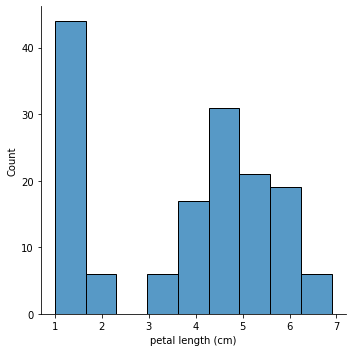

In [27]:
sns.displot(iris_dataframe["petal length (cm)"]);

Použijme nejprve **StandardScaler**. Vidíme, že data jsou nyní vycentrovaná na nule a i šířka oblasti, ve které je najdeme, je užší.

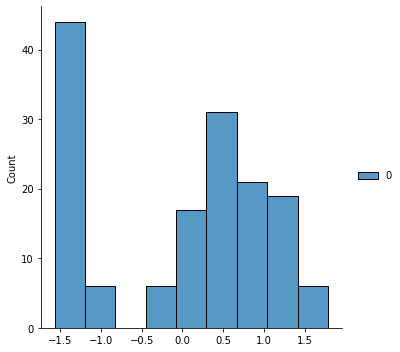

In [28]:
from sklearn.preprocessing import StandardScaler

scaler_standard = StandardScaler()
pet_len_scaled_standard = scaler_standard.fit_transform(iris_dataframe[["petal length (cm)"]])
sns.displot(pet_len_scaled_standard);

Všimněte si, že byl vytvořen a nafitován scalovací objekt. Ten (resp. jeho metodu **transform**) bychom mohli použít na naškálování dalších dat. Toho se využívá při přípravě trénovacích a testovacích dat. Tyto dvě množiny dat totiž nemůžeme škálovat samostatně. Tehdy by se totiž ztratila souvztažnost mezi daty, která existuje v neupravených hodnotách, ale která by byla vymazaná škálováním. Tím mám na mysli, že pokud by trénovací a testovací data byla vycentrovaná na lehce odlišnou hodnotu, po separátním škálováním by tato informace zmizela. Také není přípustné škálování dat před jejich rozdělením na trénovací a testovací množinu - v takovém případě by testovací data mohla díky škálování ovlivnit podobu naškálovaných trénovacích dat a tudíž i modelu. Jediný správný postup spočívá ve vytvoření škálovacího objektu na základě trénovacích dat a následné použití tohoto objektu na naškálování jak trénovacích, tak testovacích záznamů.  
Ze škálovacího objektu můžeme dostat parametry původních dat, tj. střední hodnotu a varianci, resp. standardní odchylku:

In [29]:
print(f"Mean: {scaler_standard.mean_}")
print(f"Variance: {scaler_standard.var_}")
print(f"Standard deviation: {scaler_standard.scale_}")

Mean: [3.758]
Variance: [3.09550267]
Standard deviation: [1.75940407]


Díky uložení těchto parametrů je možné provést i inverzní transformaci:

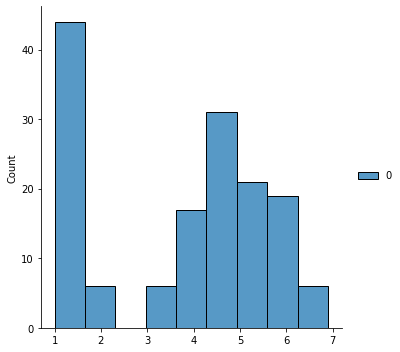

In [30]:
data_after_inverse = scaler_standard.inverse_transform(pet_len_scaled_standard)
sns.displot(data_after_inverse);

Existují i jiné škalovače než ten založený na nulové střední hodnotě a jednotkové varianci. Například **MinMaxScaler** škáluje data tak, aby se při nezměněném tvaru jejich distribuce vešla mezi minimální a maximální hodnoty (defaultně 0 a 1).  **RobustScaler** je zase založen na škálování na 25 a 75 percentil a tudíž je necitlivý na outliery. 

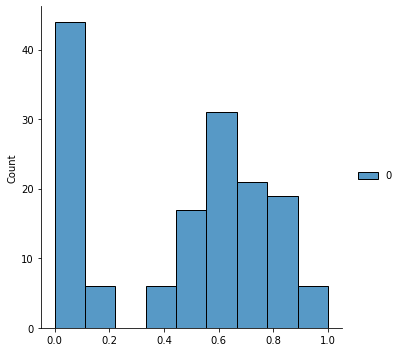

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
pet_len_scaled_minmax = scaler_minmax.fit_transform(iris_dataframe[["petal length (cm)"]])
sns.displot(pet_len_scaled_minmax);

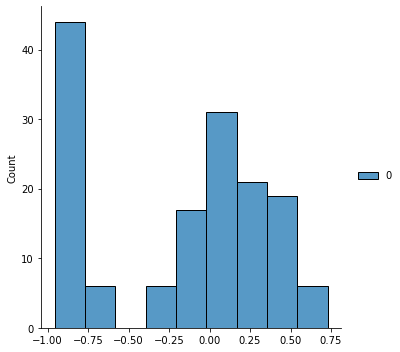

In [32]:
from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
pet_len_scaled_robust = scaler_robust.fit_transform(iris_dataframe[["petal length (cm)"]])
sns.displot(pet_len_scaled_robust);

Kdy použít které škálování? Popravdě nemám dostatek zkušeností, abych tady mohl vynášet nějaké finální soudy. Ale asi se dá říct, že když jsou data zatížená outliery, má se použít RobustScaler, když mají data normální rozložení, tak StandardScaler, a v ostatních případech MinMaxScaler.

Zmiňme ještě krátce normalizaci. Tento termín se občas volně zaměňuje se škálováním. Nicméně **Normalizer**, který je v rámci sklearnu k dispozici, se svou funkčností odlišuje od škálovacích objektů zmíněných výše. Působí totiž nikoli na sloupce, ale na řádky. Fakticky provádí normalizaci vektorů jednotlivých záznamů - viz příklad níže. Využití spočívá asi hlavně v textových úlohách, kdy by byly jednotlivé dokumenty reprezentovány řádky dataframu. 

In [33]:
column_1 = [1,2,1,0]
column_2 = [1,2,0,0]
column_3 = [1,2,0,0]
dataframe_for_norm = pd.DataFrame({
    "column_1": column_1,
    "column_2": column_2,
    "column_3": column_3,
})
dataframe_for_norm

column_1  column_2  column_3
0         1         1         1
1         2         2         2
2         1         0         0
3         0         0         0

In [34]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalized_data = normalizer.fit_transform(dataframe_for_norm)
normalized_data

array([[0.57735027, 0.57735027, 0.57735027],
       [0.57735027, 0.57735027, 0.57735027],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

## 1.7 Oversampling
Představme si situaci, kdy máme v trénovacích datech 990 záznamů třídy 0 a 10 záznamů třídy 1. V takovém případě bude pro ML algoritmus nejsnazší prohlásit o každém testovacím záznamu, že patří taky do třídy 0 - přeci jen se splete jen ve velice malém počtu případů. Problém ale nastává, když je pro nás správné rozpoznání třídy 1 kritické. Řešením je použití oversamplingu. Principielně jde o to, že ML algoritmu při trénování poskytneme více záznamů minortní třídy, než se jich v datech nachází. To se dá realizovat nejsnáze náhodným výběrem z množiny trénovacích dat o minoritní třídě, přesněji náhodným výběrem s nahrazením. Existují i jiné, pokročilejší postupy, např. SMOTE. Jeho princip v kontrastu k opakovanému vytahování stejných záznamů spočívá ve vytváření umělých nových záznamů. To se ale už dostáváme za rámec tohoto materiáludnešního výkladu.  
Pro realizaci onoho jednoduchého náhodného oversamplingu musíme importovat nový balíček - **imblearn** (=imbalanced learn), resp. jeho třídu **RandomOverSampler**. Na instanci této třídy se zavolá metoda **fit_resample** obsahující prediktory a targety.  
Nejprve si ale připravme nevybalancovaná data.

In [35]:
iris_class_0 = iris_dataframe[iris_dataframe["target"]==0]
iris_class_1 = iris_dataframe[iris_dataframe["target"]==1]
iris_class_2 = iris_dataframe[iris_dataframe["target"]==2].sample(5)
iris_before_oversampling = pd.concat(
    [iris_class_0, iris_class_1, iris_class_2],
    axis=0
)
iris_before_oversampling["target"].value_counts()

1    50
0    50
2     5
Name: target, dtype: int64

Nyní realizujme oversampling.

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
features_resampled, target_resampled = ros.fit_resample(
    iris_before_oversampling.drop("target", axis=1),
    iris_before_oversampling["target"]
)

Když se nyní podíváme na resamplovaná data, vidíme, že záznamů s prediktory i s targety je 150 a všechny třídy jsou zastoupeny stejně.

In [37]:
import collections 
print(f"Shape of resampled feature table: {features_resampled.shape}")
counter = collections.Counter(target_resampled)
counter

Shape of resampled feature table: (150, 4)


Counter({0: 50, 1: 50, 2: 50})

Zmiňme závěrem, že oversampling by se měl vypustit jen a pouze na data trénovací. Data testovací slouží na zjištění, jak se asi model bude chovat na reálných predikovaných záznamech a tudíž tato testovací data musí mít skutečnou distribuci predikovaných tříd. Snad poslední věc - oversampling je jen a pouze věcí klasifikačních úloh - regresní úlohy ho nepotřebují.

# 2. Algoritmy

## 2.1 Lineární regrese
V případě lineární regrese se snažíme proložit trénovací záznamy alias body v N rozměrném prostoru vhodnou nadrovinou  
$f(x)=w_0 + \sum_{i=1}^{N-1} w_i x_i$  
Zde $w_i$ jsou váhy, $x_i$ jednotlivé prediktory záznamu a N-1 počet prediktorů. Pakliže má prostor dimenzi dva, tj. záznamy mají pouze jeden prediktor a cíl, znamená to, že v 2D grafu prokládáme body přímkou. Relativně rozumných přímek/nadrovin bychom ale mohli vyrobit povícero. Jak poznat, která z nich je ta správná? Používá se metodika založená na mnimalizaci kvadrátů reziduí:  
$\sum_{j=1}^n(y_j - f(x_j))^2$    
Reziduum je definované jako rozdíl hodnoty cíle a nadroviny po dosazení prediktorů záznamu, tj.  
$r_j = y_j - f(x_j)$  
Zde index j označuje jednotlivé záznamy alias body v grafu. V ideálním případě, kdy by všechny záznamy ležely na predikované nadrovině, by všechna rezidua byla nulová. Proč se musí minimalizovat suma jejich kvadrátu? Kdybychom minimalizovali sumu nijak neupravených reziduí, navzájem by se požírala kladná a záporná residua. Tudíž je potřeba od nich odstranit znaménka. To se dá provést například absolutní hodnotou, nebo právě kvadrátem. U něj bývá užitečné, že zdůrazňuje význam odlehlejších bodů (outlierů). Samozřejmě to je výhodou pouze v případě, že ony odlehlé body reprezentují realitu, tj. nejedná se o chybná data. Pokud by nastal druhý případ, je nutné body vyhodit či opravit.  
Na co si dát krom outlierů pozor?
- lineární regrese je lineární. Proto snaha nafitovat (= proložit) dejme tomu parabolu pomocí funkce $f(x) = 3x_1+ 2x_2 +3$ neskončí dobře. Samozřejmě si můžeme vyrobit další prediktor jako kvadrát původního prediktoru. Nicméně obvykle nevíme, jak přesně nelineární závislost cíle na prediktorech vypadá. Tudíž bychom museli pro každý prediktor i jejich kombinace dělat mocniny i odmocniny všelijakých řádů. Tím by se model zbytečně nafouknul do počtu prediktorů, jeho interpretovatelnost by poklesla a navíc by bylo explicitní přepočítávání prediktorů poněkud únavné.
- lineární regrese nemá rádá korelaci prediktorů. Samozřejmě je ideální, pokud všechny prediktory co nejvíce korelují s cílem. Pokud ale korelují mezi sebou navzájem, znamená to, že do modelu přinášejí navíc čím dál tím menší penzum informací. Pokud by korelovaly na 100 %, například v případě zkopírovaného prediktoru, byla by nová informace v případě kopie nulová. To by sice vadit nemuselo, meziprediktorová korelace má ale bohužel na modely nikoli neutrální, nýbrž negativní vliv. Výpočet jednotlivých koeficientů nadroviny má totiž tendenci v takovýchto případech selhávat.
- představme si, že máme 2D data, tj. jeden prediktor a jeden cíl. Hodnoty prediktoru jdou od 10 do 100. Na základě takovýchto dat vytvoříme model. Následně přijdou data k predikování, kde hodnota prediktoru bude kolem 1000. V takovém případě je model zjevně nepoužitelný, neboť se setkává s daty mimo svou oblast působnosti.

Nicméně jak bychom reálně lineární regresi realizovali? Jedná se o regresní, nikoli klasifikační algoritmus, takže ji vypustíme na boston dataset. Data si nejprve naškálujeme. U čisté regrese to není bezpodmínečně nutné (narozdíl od lassa a ridge regrese - viz dále). Nicméně díky škálování budeme moci snadněji interpretovat váhu jednotlivých prediktorů. Mimochodem pokud se divíte, proč se ve funkci **train_test_split** objevil parametr random_state. Ten zajišťuje, že výstup funkce bude pro daná data vždy stejný, ať ji už spustím já při psaní tohoto textu anebo později Vy.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2, random_state=10)

scaler_boston_minmax = MinMaxScaler()
train_scal_feat_boston = pd.DataFrame(
    scaler_boston_minmax.fit_transform(train_feat_boston),
    columns=train_feat_boston.columns
)
test_scal_feat_boston = pd.DataFrame(
    scaler_boston_minmax.transform(test_feat_boston),
    columns=test_feat_boston.columns
)

Zkontrolujme, jak je to s korelací mezi jednotlivými prediktory. No, žádná sláva to není. Vidíme kupříkladu, že znečištění silně kladně koreluje s přítomností průmyslu, stářím budov či zaplacenými daněmi (za to primárně může spíš ten průmysl), silně negativně pak s vzdáleností od "Boston employment centres". Za normálních okolností bychom asi některé sloupce vyhodili anebo předtvořily pomocí PCA (Principal Component Analysis), případně bychom aplikovali ridge/lasso regresi. Nyní ale sloupce ponecháme tak, jak jsou.

In [39]:
train_scal_feat_boston.corr()

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.199866  0.387325 -0.057731  0.408119 -0.182210  0.353077   
ZN      -0.199866  1.000000 -0.544446 -0.047487 -0.520063  0.337289 -0.580448   
INDUS    0.387325 -0.544446  1.000000  0.060823  0.758244 -0.400881  0.663426   
CHAS    -0.057731 -0.047487  0.060823  1.000000  0.100434  0.088855  0.102421   
NOX      0.408119 -0.520063  0.758244  0.100434  1.000000 -0.315476  0.743112   
RM      -0.182210  0.337289 -0.400881  0.088855 -0.315476  1.000000 -0.265333   
AGE      0.353077 -0.580448  0.663426  0.102421  0.743112 -0.265333  1.000000   
DIS     -0.377467  0.669071 -0.726388 -0.102687 -0.775236  0.218743 -0.760473   
RAD      0.610499 -0.316475  0.582367 -0.000292  0.599001 -0.187149  0.458281   
TAX      0.565743 -0.329322  0.707033 -0.028541  0.656064 -0.280645  0.513523   
PTRATIO  0.283986 -0.398882  0.384332 -0.117571  0.178076 -0.326818  0.271001   
B       -0.357775  0.181256 -0.356337  0.053841 -0.381778  0.081084 -0.279600   
LSTAT    0.417695 -0.435471  0.614034 -0.044900  0.605260 -0.584827  0.637544   

              DIS       RAD       TAX   PTRATIO         B     LSTAT  
CRIM    -0.377467  0.610499  0.565743  0.283986 -0.357775  0.417695  
ZN       0.669071 -0.316475 -0.329322 -0.398882  0.181256 -0.435471  
INDUS   -0.726388  0.582367  0.707033  0.384332 -0.356337  0.614034  
CHAS    -0.102687 -0.000292 -0.028541 -0.117571  0.053841 -0.044900  
NOX     -0.775236  0.599001  0.656064  0.178076 -0.381778  0.605260  
RM       0.218743 -0.187149 -0.280645 -0.326818  0.081084 -0.584827  
AGE     -0.760473  0.458281  0.513523  0.271001 -0.279600  0.637544  
DIS      1.000000 -0.499287 -0.543117 -0.235391  0.293579 -0.524102  
RAD     -0.499287  1.000000  0.908534  0.471322 -0.439830  0.459882  
TAX     -0.543117  0.908534  1.000000  0.467863 -0.435913  0.526104  
PTRATIO -0.235391  0.471322  0.467863  1.000000 -0.166390  0.362029  
B        0.293579 -0.439830 -0.435913 -0.166390  1.000000 -0.328199  
LSTAT   -0.524102  0.459882  0.526104  0.362029 -0.328199  1.000000

Realizujme nyní samotné fitování modelu. Konstruktor pro lineární regresi narozdíl od modelů zmíněných dále moc parametrů neobsahuje. Je mezi nimi sice možnost automaticky prediktory naškálovat, ale dokumentace stejně doporučuje provést škálování separátně. Samotné učení se modelu se realizuje pomocí metody **fit**, která dostává jako parametry jednak sadu prediktorů, jednak cíl.

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()
lin_reg_model.fit(train_scal_feat_boston, train_target_boston)

LinearRegression()

Jakmile je model nafitován, můžeme se podívat jednak na koeficienty alias váhy jednotlivých prediktorů, jednak na intercept. Intercept je v 2D případě průsečík fitem získané přímky s osou y; jeho význam je de facto hodnota targetu, když by byly všechny prediktory nulové.

In [42]:
print(f"Intercept: {lin_reg_model.intercept_}")
print("Coeficients:")
print(lin_reg_model.coef_)

Intercept: 26.290034541387254
Coeficients:
[-11.40421762   6.31981786  -0.20668081   1.97451452  -7.90818663
  16.22303314   1.58197411 -16.29757792   6.99172874  -6.33100523
  -7.71087357   4.52854267 -20.96763284]


Jelikož si asi nepamatujeme, který prediktor byl první a který poslední:

In [43]:
for feature_name, coef_value in zip(train_scal_feat_boston.columns, lin_reg_model.coef_):
    print(f"{feature_name}: {coef_value}")

CRIM: -11.40421762024435
ZN: 6.319817864609253
INDUS: -0.20668080969848202
CHAS: 1.974514516562171
NOX: -7.908186630414335
RM: 16.223033144759835
AGE: 1.581974110058411
DIS: -16.29757791989099
RAD: 6.991728740786876
TAX: -6.331005226842591
PTRATIO: -7.710873573312524
B: 4.528542666429256
LSTAT: -20.967632844115997


Vidíme tedy, že na cenu nemovitosti měl nevyšší kladný vliv počet místností. Naopak největší záporný vliv měla chudoba sousedství.  
Když chceme model aplikovat na nová data, použijeme metodu predict:

In [44]:
lin_reg_model_prediction = lin_reg_model.predict(test_scal_feat_boston)

## 2.2 Regresní metriky
Abychom mohli jednotlivé modely porovnávat, musíme mít způsob, jak nějak jejich výkon kvantifikovat. Scikit-learnovské modely pro sebe mají zadefinovanou metodu **score**, která využívá jednu z několika možných mechanik. V případě lineární regrese se jedná o tzv. $R^2$ definované jako  
$R^2 = 1-\frac{\sum_{j=1}^{N}(y_j^{real}-y_j^{pred})^2}{(y_j^{real}-y_j^{avgReal})^2}$  

Čitatel zlomku se týka rozdílu predikce a reality, zatímco jmenovatel v sobě obsahuje informaci o o tom, jak moc se skutečné hodnoty liší od svého průměru. V případě naprosté shody reality a predikce má $R^2$ hodnotu jedna, hodnota minimální ale není nijak ohraničená, může být i záporná. Tato metrika de facto říká, jak velká část variability hodnoty predikované veličiny může být vysvětlena modelem.    
Skore můžeme aplikovat na trénovací i testovací data, pro zhodnocení výkonu modelu je samozřejmě relevantní druhý případ. Pokud je trénovací skore mnohem vyšší než to testovací, zřejmě došlo k overfitu. To znamená, že se model naučil strukturu trénovacích dat, což mu sice tato konkrétní data umožňuje lehce uhádnout, ale obecnost modelu a tudíž jeho schopnost predikovat data testovací tím znatelně trpí.

In [45]:
training_score = lin_reg_model.score(train_scal_feat_boston, train_target_boston)
testing_score = lin_reg_model.score(test_scal_feat_boston, test_target_boston)
print(f"Training R2 score: {training_score}")
print(f"Testing R2 score: {testing_score}")

Training R2 score: 0.750121534530608
Testing R2 score: 0.6709339839115638


Co ale dělat, když bychom chtěli použít jiné metriky? A jaké metriky máme vlastně v případě regrese k dispozici? Inu, nalezneme je v sklearn.metrics. Je mezi nimi například i ve score metodě použité $R^2$. Implementace z sklearn.metric očekává, že jako první parametr dostane skutečné hodnoty cíle a že druhým parametrem bude predikce:

In [46]:
from sklearn.metrics import r2_score

training_score = r2_score(
    train_target_boston,
    lin_reg_model.predict(train_scal_feat_boston)
)
testing_score = r2_score(
    test_target_boston,
    lin_reg_model.predict(test_scal_feat_boston)
)
print(f"Training R2 score: {training_score}")
print(f"Testing R2 score: {testing_score}")

Training R2 score: 0.750121534530608
Testing R2 score: 0.6709339839115638


Podle očekávání je výsledek stejný jako u **score** metody modelu.  
Další metrikou může být například mean squared error počítající průměrný kvadrát odchylky mezi predikovanou a reálnou hodnotou:

$MSE(y^{real}, y^{pred}) = \frac{1}{n_{samples}}\sum_{j=0}^{n_{samples}-1}(y_j^{real} - y_j^{pred})^2$  

Očividně ideál je nula a čím je MSE větší, tím je výkon modelu horší. Číslo, které získáme odmocněním MSE, je de facto průměrná chyba predikce na jednom záznamu.

In [47]:
from sklearn.metrics import mean_squared_error

training_score = mean_squared_error(
    train_target_boston,
    lin_reg_model.predict(train_scal_feat_boston)
)
testing_score = mean_squared_error(
    test_target_boston,
    lin_reg_model.predict(test_scal_feat_boston)
)
print(f"Training MSE score: {training_score}")
print(f"Testing MSE score: {testing_score}")

Training MSE score: 19.23085887937306
Testing MSE score: 34.41396845313846


## 2.3 Ridge a lasso regrese
Lineární regrese se snaží o co nejvěrnější lineární aproximaci cíle s pomocí všech prediktorů. To ale nemusí být optimální. Cílová hodnoty jsou vždy zatíženy šumem a ne každý prediktor má dostatečnou vypovídací hodnotu. To ve svém výsledku vede k tomu, že se počítač snaží nafitovat šum s pomocí nedůležitých prediktorů. Navíc tu máme již zmíněný problém s korelací. Naštěstí existuje řešení v podobě regularizace.  
Myšlenka za regularizací tkví v tom, že se nesnažíme minimalizovat sumu kvadrátů reziduí, nýbrž sumu kvadrátů reziduí, ke které je přičten penalizační člen. V případě ridge regrese (známé též jako L2 regularizace) minimalizujeme  
$\sum_{j=1}^n(y_j - f(x_j))^2 + \sum_{i=1}^m\alpha w_i^2$  
V případě lasso regularizace (též občas označované jako L1 regularizace) hledáme minimum u  
$\sum_{j=1}^n(y_j - f(x_j))^2 + \sum_{i=1}^m\alpha |w_i|$  
V obou případech jde první suma s indexem j přes všechny záznamy, zatímco druhá suma s indexem i přes všechny váhy napojené na jednotlivé prediktory. Konstanta $\alpha$ (shrinkage coefficient) není určema modelem, musíme ji stanovit sami. Čím je větší, tím má penalizační člen větší váhu. Kvůli tomu musí být druhá část součinu, váhy menší. No a model si tak může dovolit velké váhy jenom u opravdu důležitých prediktorů, které pomohou první člen stáhnout významně dolů.  
Jak se projeví podoba penalizačního členu na modelu, tj. jak se liší ridge a lasso regularizace? Ridge velice efektivně zmenšuje jednotlivé váhy, nicméně nikdy je úplně nestlačí na nulu. Naproti tomu lassu s nulováním problém nemá a tak de facto automaticky vyhodí zbytečné prediktory. Proč tedy vůbec ridge zmiňujeme, když se lasso tváří, že zvládne dvě věci naráz? Pokud bychom měli relativně slabý, ale pořád užitečný prediktor, lasso by ho mohlo vyhodit. Tudíž by pak byl lasso model méně přesný než ridge model.  
Existuje ještě tzv. elastic-net. Jedná se de facto o to, že v minimalizovaném výrazu vystupuje jak ridge, tak lasso člen
$\sum_{j=1}^n(y_j - f(x_j))^2 + \sum_{i=1}^m\alpha \rho |w_i| + \sum_{i=1}^m\frac{\alpha(1-\rho)}{2} w_i^2$  
Zde $\rho$ značí člen vyjadřující, ja má být ta která regularizace proporcielně silná.  
Před implementací regularizace v scikit-learnu zmiňme ještě jednu podstatnou skutečnost. U čisté lineární regrese nebylo škálování nutné. V případě regularizací by nenaškálovaná data vedla k tomu, že i váhy by byly nesouměřitelné. To ale není kompatibilní s celou myšlenkou stojící za penalizačním členem.  

In [48]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

ridge_model = Ridge()
ridge_model.fit(train_scal_feat_boston, train_target_boston)

lasso_model = Lasso()
lasso_model.fit(train_scal_feat_boston, train_target_boston)

elasticnet_model = ElasticNet()
elasticnet_model.fit(train_scal_feat_boston, train_target_boston)

training_ridge_score = ridge_model.score(train_scal_feat_boston, train_target_boston)
testing_ridge_score = ridge_model.score(test_scal_feat_boston, test_target_boston)
print(f"Training ridge score: {training_ridge_score}")
print(f"Testing ridge score: {testing_ridge_score}")

training_lasso_score = lasso_model.score(train_scal_feat_boston, train_target_boston)
testing_lasso_score = lasso_model.score(test_scal_feat_boston, test_target_boston)
print(f"Training lasso score: {training_lasso_score}")
print(f"Testing lasso score: {testing_lasso_score}")

training_elasticnet_score = elasticnet_model.score(train_scal_feat_boston, train_target_boston)
testing_elasticnet_score = elasticnet_model.score(test_scal_feat_boston, test_target_boston)
print(f"Training elasticnet score: {training_elasticnet_score}")
print(f"Testing elasticnet score: {testing_elasticnet_score}")

Training ridge score: 0.7455334545732715
Testing ridge score: 0.666429781110345
Training lasso score: 0.22805239137229605
Testing lasso score: 0.09431861897045679
Training elasticnet score: 0.16176486492568842
Testing elasticnet score: 0.025238503156797876


## 2.4 Křížová validace (cross-validation) a GridSearch
Viděli jsme, že testovací skore pro ridge bylo srovnatelné se skorem pro normální lineární regresi. Naproti tomu skore pro lasso a elatic-net byly tragické. To mohlo být mimo jiné dáno pro danou úlohu nevhodnou defaultní hodnotou hyperparametrů $\alpha$ a $\rho$. Jak jsme si již řekli, není vhodné nyní ladit hodnotu těchto parametrů podle testovacího skore. Měli bychom si z trénovacích dat oddělit validační množinu a s její pomocí hyperparametry určit. Nicméně využívání indexů z k-foldingu je relativně pracné a člověk při tom může udělat chybu. Naštěstí existuje jednodušší varianta - GridSearchCV.  
Jak GridSearchCV funguje? Data, která jsou mu předána v rámci metody fit, rozdělí na trénovací a validační množiny. Automaticky provádí K-folding, přičemž defaultní počet foldů je 5. Na každém foldu se provede validace pro každou kombinaci parametrů, které jsou spolu se samotným ML modelem GridSearchCV předány v konstruktoru.

In [49]:
from sklearn.model_selection import GridSearchCV

ridge_params = {
    "alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
}
gridseach_ridge = GridSearchCV(ridge_model, ridge_params)
gridseach_ridge.fit(train_scal_feat_boston, train_target_boston)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

Pakliže se chceme podívat na nejlepší model, zeptáme se na atribut best_estimator_.

In [50]:
gridseach_ridge.best_estimator_

Ridge(alpha=0.1)

Pokud chceme vidět podrobnosti výpočtu, například hodnoty metriky pro jednotlivé foldy, případně průměrnou metriku pro daný parametr/kombinaci parametrů přes všechny foldy, zeptáme se na atribut cv_results_.

In [51]:
gridseach_ridge.cv_results_

{'mean_fit_time': array([0.00399313, 0.00291796, 0.00100627, 0.00295801, 0.00202336,
        0.00302019, 0.002244  ]),
 'std_fit_time': array([0.00381742, 0.0023879 , 0.00201254, 0.00389077, 0.00404673,
        0.00203134, 0.00224884]),
 'mean_score_time': array([0.        , 0.        , 0.00302143, 0.        , 0.00100174,
        0.00192695, 0.00121403]),
 'std_score_time': array([0.        , 0.        , 0.00246716, 0.        , 0.00200348,
        0.00159103, 0.00242805]),
 'param_alpha': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 100},
  {'alpha': 1000}],
 'split0_test_score': array([0.66287573, 0.66307319, 0.66476785, 0.66618332, 0.55501243,
        0.29837636, 0.05539734]),
 'split1_test_score': array([0.7875526 , 0.78775589, 0.78958521, 0.

Není ani potřeba takto určené parametry přepisovat do normálního modelu. Když na gridsearch objekt zavoláme funkci **predict**, použije se pro určení hodnoty cíle nejoptimálnější model.

In [52]:
training_ridge_score = r2_score(
    train_target_boston,
    gridseach_ridge.predict(train_scal_feat_boston)
)
testing_ridge_score = r2_score(
    test_target_boston,
    gridseach_ridge.predict(test_scal_feat_boston)
)
print(f"Training ridge R2 score: {training_ridge_score}")
print(f"Testing ridge R2 score: {testing_ridge_score}")

Training ridge R2 score: 0.7500528886315261
Testing ridge R2 score: 0.6709036348308193


Užitečnost jednotlivých parametrů se porovnává podle defaultní metriky ML modelu. Co ale máme dělat, když chceme metriku jinou? Použije se parametr **scoring** konstruktoru **GridSearchCV**. Nicméně je zde drobná zrada - nemůže se sem psát jméno funkce metriku počítající, např. mean_squared_error. Musí se zde uvést tzv. scorer objekt. Ten vytvoříme s pomocí funkce **make_scorer**, kterému už funkci metriky předat můžeme.  

In [53]:
from sklearn.metrics import make_scorer, mean_squared_error

ridge_params = {
    "alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
}
gridseach_ridge_mse = GridSearchCV(
    ridge_model, 
    ridge_params, 
    scoring=make_scorer(mean_squared_error)
)
gridseach_ridge_mse.fit(train_scal_feat_boston, train_target_boston)
gridseach_ridge_mse.cv_results_["mean_test_score"]

array([21.39481745, 21.38973574, 21.34954705, 21.55970121, 29.61500942,
       51.27270239, 71.02815136])

Viděli jsme, že pro ridge regresi nám GridSearchCV nepomohl - zjevně byl defaultní parametr optimální. Ovšem to už neplatí pro lasso regresi:

In [54]:
lasso_params = {
    "alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
}
gridseach_lasso = GridSearchCV(lasso_model, lasso_params)
gridseach_lasso.fit(train_scal_feat_boston, train_target_boston)

print(gridseach_lasso.best_estimator_)

training_lasso_score = r2_score(
    train_target_boston,
    gridseach_lasso.predict(train_scal_feat_boston)
)
testing_lasso_score = r2_score(
    test_target_boston,
    gridseach_lasso.predict(test_scal_feat_boston)
)
print(f"Training lasso R2 score: {training_lasso_score}")
print(f"Testing lasso R2 score: {testing_lasso_score}")

Lasso(alpha=0.01)
Training lasso R2 score: 0.7490637864381104
Testing lasso R2 score: 0.672135852986891


Stejnou věc bychom mohli říci i o elastic-netu. Zde je mimo jiné ukázáno, jak má vypadat zápis hyperparametrů, když chceme  optimalizovat několik z nich naráz.

In [55]:
elasticnet_params = {
    "alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "l1_ratio":[0.05, 0.1, 0.3, 0.5, 0.7, 1]
}
gridseach_elasticnet = GridSearchCV(elasticnet_model, elasticnet_params)
gridseach_elasticnet.fit(train_scal_feat_boston, train_target_boston)

print(gridseach_elasticnet.best_estimator_)

training_elasticnet_score = r2_score(
    train_target_boston,
    gridseach_elasticnet.predict(train_scal_feat_boston)
)
testing_elasticnet_score = r2_score(
    test_target_boston,
    gridseach_elasticnet.predict(test_scal_feat_boston)
)
print(f"Training elastic-net R2 score: {training_elasticnet_score}")
print(f"Testing elastic-net R2 score: {testing_elasticnet_score}")

ElasticNet(alpha=0.001, l1_ratio=0.05)
Training elastic-net R2 score: 0.7492394843632009
Testing elastic-net R2 score: 0.67018856460445


Na závěr zdůrazněme, že GridSearch se **NESMÍ** použivat současně s oversamplingem. Výsledkem by totiž bylo, že by se naklonované záznamy dostaly do trénovacích i validačních dat a došlo by k overfitu a přehnaně optimistickým metrikám. Nicméně pipeliny z imblearnu se už s GridSearchem snad používat dají.

## 2.5 Logistická regrese
Ačkoli se to z názvu nezdá, logistická regrese není úlohou regresní, nýbrž klasifikační. Cílem tedy není určení nějakého reálného čísla jdoucího od mínus nekonečna do plus nekonečna, ale pravděpodobnosti toho, že záznam spadá do určité třídy. Tato pravděpodobnost pak může nabývat hodnot od nuly do jedné. V binárních úlohách, tj. v úlohách, kde jsou třídy jenom dvě, se stanovuje nějaký threshold pravděpodobnosti, obvykle 0,5. Když pak pro záznam pravděpodobnost threshold pro danou třídu překročí, prohlásí se, že onen záznam do příslušné třídy patří. Situace pro více tříd je lehce komplikovanější. Obvykle se pro každou třídu natrénuje speciální model, přičemž jednička v targetu znamená, že záznam patří do dané třídy, 0, že patří do libovolné z tříd ostatních. Při predikci pak člověk z modelů dostane u jednoho záznamu pro každou třídu určitou pravděpodobnost a záznam je přiřazen třídě s pravděpodobností nejvyšší.  
Nicméně vraťme se k binárnímu problému. Člověk by si mohl myslet, že by i takovouto situaci vyřešila lineární regrese. Na příkladu níže máme body nacházející se na ose x nalevo od nuly s hodnotou (třídou) 0 a body napravo s třídou 1. Ty lze proložit přímkou, která je pro x<0 pod 0,5, pro x>0 nad 0,5 a pro x=0 na 0,5.

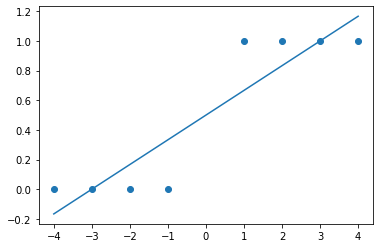

In [56]:
from sklearn.linear_model import LinearRegression

lin_reg_dataframe = pd.DataFrame({
    "x_axis": [-4, -3, -2, -1, 1, 2, 3, 4],
    "y_axis": [0, 0, 0, 0, 1, 1, 1, 1]
})
faux_class_model = LinearRegression()
faux_class_model.fit(lin_reg_dataframe[["x_axis"]], lin_reg_dataframe["y_axis"])

plt.scatter(
    x=lin_reg_dataframe["x_axis"],
    y=lin_reg_dataframe["y_axis"]
)
plt.plot(lin_reg_dataframe["x_axis"], 
         faux_class_model.coef_*lin_reg_dataframe["x_axis"]+faux_class_model.intercept_
        )

Vložme ale nyní pár bodů nulové kategirie hodně nalevo. Směrnice přímky se zmenší a některé záznamy s jedničkovou kategoriií jsou označeny jako nulové. Přitom se ale trénovací body v důležité oblasti kolem x=0 nezměnily. Zjevně tudíž není regrese pro klasifikaci dostatečně robustní.

Coefficient: [0.01520284]
Intercept: 0.45899960614415125
Quasi-probability for x=2: [0.48940528]


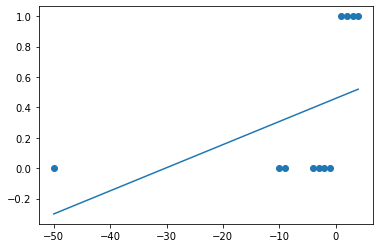

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg_dataframe = pd.DataFrame({
    "x_axis": [-50,-10,-9, -4, -3, -2, -1, 1, 2, 3, 4],
    "y_axis": [0,0, 0,0, 0, 0, 0, 1, 1, 1, 1]
})
faux_class_model = LinearRegression()
faux_class_model.fit(lin_reg_dataframe[["x_axis"]], lin_reg_dataframe["y_axis"])

plt.scatter(
    x=lin_reg_dataframe["x_axis"],
    y=lin_reg_dataframe["y_axis"]
)
plt.plot(lin_reg_dataframe["x_axis"], 
         faux_class_model.coef_*lin_reg_dataframe["x_axis"]+faux_class_model.intercept_
        )
print(f"Coefficient: {faux_class_model.coef_}")
print(f"Intercept: {faux_class_model.intercept_}")
print(f"Quasi-probability for x=2: {faux_class_model.intercept_+faux_class_model.coef_*2}")

Inu dobrá, lineární regrese se pro klasifikaci použít nedá. Nicméně nemůžeme popřít, že velice přirozené do sebe zahrnuje vliv všech prediktorů. Co s tím?  
Definujme si *p* jako pravděpodobnost toho, že v binárním problému bude cílová třída jedničková. Poté musí platit, že pravděpodobnost třídy nulové bude vyjádřena jako 1-*p*. Poté poměr těchto dvou pravděpodobností, tj. p/(1-p), bude značit, kolikrát je pro ten konkrétní záznam pravděpodobnější třída jedna než třída nula. Vyslovme předpoklad, že logaritmus tohoto poměru se dá vyjádřit jako lineární kombinace prediktorů, tj.  
$ln(\frac{p}{1-p}) = w_0 + \sum_{i=1}^{N-1} w_i x_i$  
Na obě strany rovnice vypustíce exponenciálu a následně vynásobíme (1-*p*), vydělíme *p* a tou exponenciálou s prediktory. Po následném převedení jedničky z p-čkové části na část s exponenciálou budeme mít  
$\frac{1}{p} = \frac{1+exp(w_0 + \sum_{i=1}^{N-1} w_i x_i)}{exp(w_0 + \sum_{i=1}^{N-1} w_i x_i)}$  
Čitatele i jmenovatele výrazu napravo vynásobíme $exp[-(w_0 + \sum_{i=1}^{N-1} w_i x_i)]$, následně obě strany zase invertujeme. Tím získáme
$p = f(x) = \frac{1}{1+\exp(-(w_0 + \sum_{i=1}^{N-1} w_i x_i))}$  
Tato věc se nazývá logistická funkce. Má tu vlastnost, že narozdíl od lineární funkce z lin. regrese nepromítá reálná čísla na reálná čísla, ale na interval [0, 1]. Platí pro ni také to, že $f(+\infty)$ = 1 a $f(-\infty)$ = 0. Její tvar lze nahlédnout z následujícího obrázku.

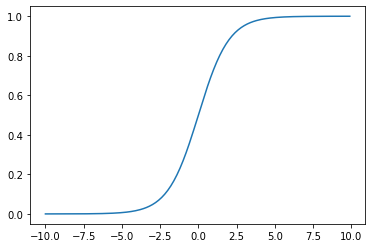

In [58]:
x_axis = [number/10 for number in range(-100,100)]
y_axis = [1/(1+math.exp(-x)) for x in x_axis]
plt.plot(x_axis, y_axis)

Lineární regrese hledá optimální parametry minimalizací sumy čtverců reziduí. Stejná metodika pro klasifikaci by ale optimální nebyla. Co tedy použít? Pokud je reálná třída 1, chceme penalizovat pravděpodobnosti menší než jedna. Tuto podmínku splňuje $-log_{10}(f(x))$. Pokud je v tomto výrazu f(x) = 1, je celý vztah roven 0, pokud platí f(x) = 0, celý vztah se rovná + nekonečnu. Naopak pro reálnou třídu 0 penalizujeme nenulové přepovězené pravděpodobnosti toho, že třída bude 1. To lze realizovat pomocí $-log_{10}(1-f(x))$. Když to celé dáme dohromady, máme  
$-\sum_{j=1}^m(y_j log_{10}(f(x_j, w)) + (1-y_j)log_{10}(1-f(x_j, w)))$  

Nicméně to všechno pro nás bude počítat počítač. Jak ho k tomu donutit?  
Připravme si napřed kosatcová data:

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)

scaler_iris_minmax = MinMaxScaler()
train_scal_feat_iris = pd.DataFrame(
    scaler_iris_minmax.fit_transform(train_feat_iris),
    columns=train_feat_iris.columns
)
test_scal_feat_iris = pd.DataFrame(
    scaler_iris_minmax.transform(test_feat_iris),
    columns=test_feat_iris.columns
)

Nyní realizujme samotné naučení modelu.

In [60]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_scal_feat_iris, train_target_iris)

LogisticRegression(max_iter=1000)

Asi je vhodné poznamenat, že sklearnovské logistická regrese nejen podporuje regularizaci v rámci "základní" funkce, ale dokonce je tato regularizace defaultně zapnuta. Nejdůležitější parametry vstupující do konstruktoru se tak týkají právě jí. Jedná se zejména o parametr **penalty**, jímž se nastavuje typ regularizace ("l1", "l2" - ta je defaultní, "elasticnet"). Dále tu máme parametr **C** mající význam inverze síly regularizace. V příkladu výše používáme parametr **max_iter**. Občas se stane, že po natrénování uvidíme hlášku, kde si počítač stěžuje na to, že v nastaveném počtu iterací (100) model nezkonvergoval. Řešením je tak použít větší počet iterací. Nakonec zmiňme parametr **class_weight**. Ten má defaultně hodnotu None, lze mu ale přiřadit i hodnotu "balanced". Pokud se tak stane, budou na základě výskytu tříd v targetu při trénování inverzně upraveny váhy. Tudíž není v případě tohoto algoritmu nutno použít oversampling.

Jaké atributy jsou u natrénovaného modelu dostupné? Jedná se jednak o seznam tříd.

In [61]:
log_reg_model.classes_

array([0, 1, 2])

Dále tu jsou koeficienty pro každou třídu (jejich počet = počet prediktorů * počet tříd) a intercept ("průnik s osou y").

In [62]:
log_reg_model.coef_

array([[-1.2893383 ,  1.45853356, -2.5290202 , -2.49881729],
       [ 0.307284  , -1.33803348,  0.28494028, -0.35815852],
       [ 0.9820543 , -0.12050008,  2.24407992,  2.85697581]])

In [63]:
log_reg_model.intercept_

array([ 2.01022721,  0.95573748, -2.96596469])

Jaký je vlastně význam koeficientů v logistické regresi? To lze nahlédnout ze vzorečků resp. úvah uvedených výše při odvozování logistické funkce. Pokud bychom při tvorbě modelu nepoužili žádný prediktor, platilo by  
$log(\frac{p}{1-p}) = intercept$  
Tudíž "základní" pravděpodobnost jedničkové třídy nad pravděpodobností třidy nulové by byla exp(interpect) krát větší. Když prediktory použijeme, říká koeficient u toho konkrétního prediktoru, jak moc jednotkový nárůst onoho prediktoru povede k proporčnímu zvýšení pravděpodobnosti třídy 1.

Pro predikci použijeme nepřekvapivě metodu **predict**:

In [64]:
log_reg_model.predict(test_scal_feat_iris)

array([1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 2, 0, 0, 0, 2, 2,
       2, 0, 1, 0, 1, 1, 1, 2])

Pokud chceme vidět pravděpodobnosti, dostaneme pro každý záznam pravděpodobnost všech tříd:

In [65]:
log_reg_model.predict_proba(test_scal_feat_iris)

array([[0.05826988, 0.64061264, 0.30111748],
       [0.01931669, 0.35023558, 0.63044773],
       [0.88825669, 0.10391185, 0.00783147],
       [0.09979923, 0.49599445, 0.40420633],
       [0.85930855, 0.13345712, 0.00723432],
       [0.16120858, 0.7263269 , 0.11246452],
       [0.04095403, 0.52975578, 0.42929019],
       [0.17701852, 0.62185636, 0.20112512],
       [0.86280955, 0.12938266, 0.0078078 ],
       [0.1196116 , 0.55980954, 0.32057887],
       [0.11687401, 0.48504785, 0.39807815],
       [0.03063411, 0.38693565, 0.58243024],
       [0.10386304, 0.66171228, 0.23442469],
       [0.81476465, 0.17724818, 0.00798717],
       [0.90327059, 0.08906175, 0.00766767],
       [0.01209779, 0.2352122 , 0.75269001],
       [0.11946181, 0.38927175, 0.49126643],
       [0.85269196, 0.14168448, 0.00562356],
       [0.88198163, 0.10796313, 0.01005524],
       [0.85615838, 0.13725435, 0.00658727],
       [0.00758803, 0.20394839, 0.78846358],
       [0.00992991, 0.23906522, 0.75100487],
       [0.

Pro model exituje i metoda score, která ukazuje accuracy. Tím se dostáváme k otázce, jak měřit kvalitu klasifikačních algoritmů.

In [66]:
log_reg_model.score(test_scal_feat_iris, test_target_iris)

0.9666666666666667

## 2.6 Metriky klasifikátorů
První věc, která nás napadne, je nechat si vypsat, jak se měl počet záznamů té které třídy ve skutečnosti a podle predikce. Toho můžeme dosáhnout buďto prostřednictvím pandasí **crosstab**, anebo s pomocí sklearnovské **confusion_matrix**.  
U **crosstab** musíme jako první parametr dát sadu dat, které budou zgrupovány do řádků (obvykle predikce), jaku druhý parametr data, které čeká zgroupnutí do sloupců (obvykle realita).

In [67]:
pd.crosstab(
    log_reg_model.predict(test_scal_feat_iris),
    test_target_iris
)

target   0   1  2
row_0            
0       10   0  0
1        0  12  0
2        0   1  7

Pokud použijeme parametr **margins** s hodnotou True, uvidíme i součty výskytů přes jednotlivé řádky a sloupce.

In [68]:
pd.crosstab(
    log_reg_model.predict(test_scal_feat_iris),
    test_target_iris,
    margins=True
)

target   0   1  2  All
row_0                 
0       10   0  0   10
1        0  12  0   12
2        0   1  7    8
All     10  13  7   30

Pokud chceme vidět namísto počtu výskytu procentuální zastoupení, využijeme parametr **normalize**. Do něj vložíme hodnotu v závislosti na tom, jestli chceme normalizaci provést přes všechny hodnoty (**normalize="all"**), přes řádky (**normalize="index"**) či přes sloupce (**normalize="columns"**).

In [69]:
pd.crosstab(
    log_reg_model.predict(test_scal_feat_iris),
    test_target_iris,
    normalize="index"
)

target    0      1      2
row_0                    
0       1.0  0.000  0.000
1       0.0  1.000  0.000
2       0.0  0.125  0.875

Do confusion matice by se dle dokumentace měla jako první parametr umístit faktické třídy a jako druhý třídy predikované. Tím pádem je realita v řádcích a predikce ve sloupcích.

In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    test_target_iris,
    log_reg_model.predict(test_scal_feat_iris)
)

array([[10,  0,  0],
       [ 0, 12,  1],
       [ 0,  0,  7]], dtype=int64)

I zde můžeme provést normalizaci přes všechno (**normalize="pred"**), přes predikce (**normalize="pred"**) či před skutečné hodnoty (**normalize="true"**)

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(
    test_target_iris,
    log_reg_model.predict(test_scal_feat_iris),
    normalize="pred"
)

array([[1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.125],
       [0.   , 0.   , 0.875]])

Nicméně co dělat, kdybychom chtěli výkon ML algoritmu zhodnotit jedním číslem? Představme si nejprve, že bychom měli binární problém, tj. že by možné třídy byly pouze dvě. Nazvěme tyto třídy jako pozitivní a negativní. V takovém případě by nám počítač mohl vypsat křížovou tabulku, kde by bylo vidět, jak byla predikce úspěšná. Ona tabulka, v jejíž sloupcích by byly záznamy do určité třídy opravdu patřící a v řádcích záznamy do dané třídy zařazené podle prediikce,  by vypadala dejme tomu takto:  

||$P_{real}$|$N_{real}$|  
|-|-|-|  
|$P_{predik}$|30|10|  
|$N_{predik}$|20|40|  

Označme si jednotlivá místa tabulky následovně:

||$P_{real}$|$N_{real}$|  
|-|-|-|  
|$P_{predik}$|TP|FP|  
|$N_{predik}$|FN|TN|  

TP = true positive, FP = false positive, FN = false negative, TN = true negative.  
Asi první metrikou, která by člověka napadla, by bylo spočítat, jaká část záznamů byla určena správně. Tuto veličinu označujeme jako **accuracy** (raději nepřekládám kvůli kolizi s názvem metriky precision). 

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$  
Accuracy je sice velmi snadno interpretovatelná, v praxi ale k nejpoužívanějším metrikám nepatří. Důvodů je několik. Zaprvé zde máme problém nestejnoměrně zastoupených tříd. Pokud je v testovací množině 990 záznamů třídy 0 a 10 záznamů třídy 1 a model je nastaven tak, že každému záznamu automaticky přidělí štítek 0, bude accuracy velká. Jenomže v takovýchto modelech nám jde právě o určování oné minoritní třídy. Nicméně accuracy nemusí být optimální ani když jsou třídy zastoupeny stejně. Pokud bychom měli test odhalující nějakou závažnou chorobu, chtěli bychom v prvé řadě dostat na minimum FN. Naproti FP nás tolik netrápí - holt jednou pozitivně označení lidé dostanou test další. No a toto bohužel accuracy zachytit nedokáže.  
Accuracy se ve sci-kit learnu spočítá s pomocí funkce **accuracy_score** z sklearn.metrics. Jejím prvním parametrem je seznam či seznamu podobná struktura obsahující skutečné třídy. Druhým parametrem je seznam predikovaných tříd (tj. např. 0 a 1, nikoli pravděpodobnosti).

Recall vystihuje schopnost modelu najít v testovacích datech všechny reprezentanty pozitivní třídy. To znamená, že pokud model označí všechny záznamy za pozitivní, recall bude roven jedné.   
$Recall = \frac{TP}{TP + FN}$  

Precision zase říká, jaká je schopnost modelu neoznačit jako pozitivní ten záznam, který je fakticky z negativní třídy. Pokud by model vybral jako pozitivní jen jeden záznam a tento výběr by byl správný, činila by precision jedna.  
$Precision = \frac{TP}{TP + FP}$  

Vidíme, že precision a recall jdou proti sobě. Čím víc záznamů model označí jako pozitivních, tím větší část množiny reálně pozitivních odhalí a tím bude větší recall, ale současně špatně oštítkuje některé negativní záznamy a precision klesne. Proto lidé vymysleli další metriku zvanou F1 score, která v sobě zahrnuje informaci o obou z nich.
$F1 = \frac{precision*recall}{precision + recall} = \frac{2TP}{2TP + FP + FN}$  
Z hledika scikit-learnu se s odpovídajícími funkcemi - **precision_score**, **recall_score**, **f1_score** - pracuje v základech stejně jako s **accuracy_score**. 

No jo, jenže všechno napsané výše platilo pro binární situace, tj. situace, kdy má člověk pouze třídy dvě. Co dělat při větším počtu tříd ukážeme na následujících řádcích. Předtím se ale ještě podívejme na  dva podobně vypadající termíny - multiclass a multilabel. Multiclass je případ kosatců - každý záznam může patřit do jedné jediné třídy. Naproti u multilabel úlohy může záznam patřit do více tříd současně. Například pokud bychom klasifikovali texty, mohl by jeden text spadat současně do sekce věnované ekonomice, politice a historii.  
Znova si ukažme křížovou tabulku pro testovací data.  

In [72]:
pd.crosstab(
    log_reg_model.predict(test_scal_feat_iris),
    test_target_iris
)

target   0   1  2
row_0            
0       10   0  0
1        0  12  0
2        0   1  7

U **accuracy_score** se žádný problém nevyskytuje ani při větším počtu tříd - zkrátka se podělí počet správně určených záznamů celkovým počtem záznamů. Tj (10+12+7)/(10+12+7+1)=0,967.

In [73]:
from sklearn.metrics import accuracy_score

accuracy_score(test_target_iris, log_reg_model.predict(test_scal_feat_iris))

0.9666666666666667

Když se o to samé pokusíme s precision_score, čeká nás pád na ValueError. Defautlní chování, specifikované hodnotou **"binary"** parametru **average**, počítá právě s binární vstupem. ValueErrorem by skončilo i **average="samples"** - to je určené pro multilabel problémy. to, co sem musíme napsat, je buďto **"micro"**, anebo **"macro"**.
Micro znamená, že se pro každou třídu spočítají TP, FP a FN a tato čísla se poté sečtou. Tj.
- třída 0: TP = 10, FP = 0, FN = 0
- třída 1: TP = 12, FP = 0, FN = 1
- třída 2: TP = 7, FP = 1, FN = 0
- celkově TP = 29, FP = 1, FN = 1  

Tudíž jak pro precision, tak recall máme ve vzorečku 28/(28+1) = 0,966.

In [74]:
from sklearn.metrics import precision_score

precision_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="micro"
)

0.9666666666666667

In [75]:
from sklearn.metrics import recall_score

recall_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="micro"
)

0.9666666666666667

Naproti tomu average="macro" znamená, že se metriky spočítají pro každou třídu zvlášť a pak se zprůměrují. Tj.
- třída 0: precision = 10/(10+0) = 1; recall = 9/(9+0) = 1
- třída 1: precision = 12/(12+0) = 1; recall = 12/(12+1) = 0,923
- třída 2: precision = 7/(7+1) = 0,875; recall = 7/(7+0)= 1
- průměr: precision = (1+1+0,875)/3 = 0,958; recall = (1+1+0,86)/3 = 0,974

In [76]:
from sklearn.metrics import precision_score

precision_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="macro"
)

0.9583333333333334

In [77]:
from sklearn.metrics import recall_score

recall_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="macro"
)

0.9743589743589745

To samé v bledě modrém platí i pro F1:

In [78]:
from sklearn.metrics import f1_score

f1_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="micro"
)

0.9666666666666667

In [79]:
f1_score(
    test_target_iris, 
    log_reg_model.predict(test_scal_feat_iris),
    average="macro"
)

0.9644444444444445

Zmiňme dále roc (receiver operator characteristic) křivku. Jedná se o graf závislosti true positive rate (=TP/(TP+FN)) na false positive rate (=FP/(TN+FP)). Ze své definice se obě osy grafu pohybují od 0 do 1. Pro ideální model by křivka grafu měla vystřelit z bodu [0,0] do bodu [0,1] a pak pokračovat do [1,1]. Naopak pro model, který je stejně spolehlivý jako hod mincí, by křivka grafu měla kopírovat diagonálu. Pro binární problém lze graf vytvořit pomocí
```python
from sklearn.metrics import plot_roc_curve

plot_roc_curve(log_reg_model, test_scal_feat_iris, test_target_iris)
```
Pro více tříd má člověk holt smůlu - roc křivka pro takový případ není definovaná.  
ROC křivku lze charakterizovat jedním údajem - plochou jí v grafu vymezenou. Mluvíme o ROC AUC aka "area under curve".Pro ideální model platí, že AUC = 1, pro házení mincí pak AUC = 0,5. Scikit learn umožňuje tuto metriku spočítat pomocí funkce **roc_auc_score**. Při použití defaultních parametrů tato funkce pro vícetřídní problém spadne na ValueError. Proto se v takovém případě musí defaultní hodnota parametru **multi_class** nastavit na **"ovr"** či **"ovo"**. Hodnota "ovr" znamená, že se pro každou třídu spočítá její AUC proti všem ostatním třídám najednou a výsledná čísla se zprůměrují. Naproti tomu "ovo" dělá průměr AUCů pro všechny možné páry tříd.      
Pozor - narozdíl od předchozích metrik se do **roc_auc_score** jako druhý parametr nedávají predikované třídy, nýbrž predikované pravděpodobnosti! 

In [80]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    test_target_iris, 
    log_reg_model.predict_proba(test_scal_feat_iris),
    multi_class="ovr"
)

0.9984917043740573

In [81]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    test_target_iris, 
    log_reg_model.predict_proba(test_scal_feat_iris),
    multi_class="ovo"
)

0.9981684981684982

Občas se ve spojitosti s modely mluví o liftu. Pod tímto termínem si představme metriku říkající, kolikrát je pro prvních X procent záznamů (seřazených podle pravděpodobnosti jendičkové třídy) natrénovaný model lepší než model žádný. Uvažme třeba eventualitu, že bychom vyvíjeli model hledající lidi kladně reagující na obchodní nabídku poslanou dopisem. Z minulosti bychom přitom věděli, že takových osob bude ze 100 000 např. 2 000. Vytvořili bychom tedy klasifikační model a s jeho pomocí bychom pro každého klienta spočítali praveděpodobnost, že na naši nabídku bude reagovat. Následně bychom klienty podle této pravděpodobnosti seřadili. Kdybychom oslovili všech 100 000 lidí, byl by výsledek stejný, jako kdyby model vůbec neexistoval. Nicméně uvažme eventualitu, že peníze na tolik obálek nemáme. Proto doufáme, že když oslovíme prvních dejme tomu 10 % klientů, dostaneme kladnou odpověď nikoli od 200 lidí, ale od X-násobně vyššího počtu. Toto číslo X označíme jako lift. Jeho závislost na procentu oslovené populace ukazuje (kumulativní) křivka liftu. Pro její vykreslení použijeme balíček scikitplot a to sice následujícím způsobem:
```python
import scikitplot as skplt

skplt.metrics.plot_lift_curve(
    test_target_iris, 
    log_reg_model.predict_proba(test_scal_feat_iris)
)
```
Možná se nyní ptáte, proč tento kód není reálně uplatněn na kosatcová data. Důvodem je skutečnost, že už ze své motivace je lift definován pouze pro binární problémy, zatímco typy kosatců máme tři. 

## 2.7 Stromy   
Stromy jsou struktury, které se skládají z
- vnitřních uzlů obsahující podmínky na separaci záznamů s odlišnými charakteristikami
- listů, kterým je přiřazen štítek třídy  

Najít strom s přesnými podmínkami dost dobře z výpočetních důvodů nejde, s efektivními algoritmy lze ale dosáhnout dostatečně přesných stromů. Zmíněné algoritmy používají greedy strategie - dělají série lokálně optimálních rozhodnutí spojených s rozdělováním záznamů do pokud možno odpovídajících větví.  
Podle čeho se ale mají rozhodnout, na základě kterého prediktoru v té které fázi záznamy rozdělí? Existuje několik metrik, které se všechny týkají rozdělování podle míry (ne)čistoty dětských uzlů. Z nich jmenujme entropii, gini či classification error definované jako  

$Entropy(t) = -\sum_{i=0}^{c-1}p(i|t) log_2p(i|t)$  
$Gini(t) = 1 - \sum_{i=0}^{c-1}|p(i|t)|^2$  
$ClassificationErrror = 1 - max_i[p(i|t)]$  

Zde p(i|t) je zlomek záznamů patřící do třídy i a nacházející se v nodu t, c značí počet tříd.  
Pro zjištění toho, jak moc vlastně štěpící kritérium pomáhá, je potřeba porovnat stupeň čistoty rodiče se stupněm čistoty dětí:  
$\Delta = I(parent) - \sum_{j=1}^{k}\frac{N(v_j)}{N}I(v_j)$  
V tomto vztahu představuje I(něco) čistotu daného nodu, N počet záznamů v rodičovském nodu a $N(v_j)$ počet záznamů v dětském nodu $v_j$. No a cílem je dosáhnout maximálního $\Delta$. V případě, že je jako měřitko nečistoty použita entropie, nazýváme $\Delta$ informačním ziskem.  
Kterou metriku by měl člověk v praxi vybrat? Je to víceméně jedno - na výkon algoritmu má volba malý vliv.

Jaké mají vlastně stromy vlastnosti?  
- nepotřebují žádné předběžné předpoklady týkající se rozdělení cílové třídy či prediktorů
- techniky k sestrojení stromů jsou výpočetně nenáročné, modely lze tak vyrobit rychle i pro velký trénovací dataset
- stromy, zejména malé, se snadno interpretují  
- stromy jsou poměrně robustní vzhledem k šumu
- prediktory korelující s jinými prediktory nekazí přesnost předpovědi stromů; nicméně do stromu se dostat mohou a tak ho zbytečně zvětší
- počet záznamů v jednom nodu s rostoucí hloubkou klesá a predikce tudíž přestává být spolehlivá; proto pokud tento počet klesne pod určitý práh, mělo by se dalšímu štěpení nodu zabránit  
- substrom může být ve stromu mnohonásobně replikován, čímž se onen strom stává obtížněji interpretovatelným
- obvykle se v jeden okamžik pro štěpící kritérium používá jen jeden prediktor  

Stromy velice ochotně overfitují. Pokud tomu chceme zabránit, je nutné použít určitou formu pruningu.  
Při **prepruning**u je je algoritmus, který strom vyrábí, zastaven před vznikem stromu perfektně fitujícího všechna trénovací data. Stopping podmínkou bývá například zastavení štěpení uzlů při určité hodnotě $\Delta$. Problémem toho přístupu je právě určení této podmínky - i když v jednom splitu není $\Delta$ moc velká, ve splitu následujícím už by velká být mohla.  
U **postpruningu** nejprve strom celý vyroste a ořezává se až posléze. To se realizuje 
- buďto tak, že se substrom nahradí novým listem, jehož třída je určena majoritní třídou v substromu
- anebo tak, že se substrom nahradí svou nejčastěji používanou větví

Obecně je postprunning lepší než preprounning, ale je výpočetně náročnější.

Tolik teorie, jak ale postupovat při vytváření stromového modelu v praxi? Postupujeme víceméně stejně jako u ostatních modelů.

In [82]:
from sklearn.tree import DecisionTreeClassifier

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)

tree_class_model = DecisionTreeClassifier()
tree_class_model.fit(train_feat_iris, train_target_iris)

print(f"Train score: {tree_class_model.score(train_feat_iris, train_target_iris)}")
print(f"Test score: {tree_class_model.score(test_feat_iris, test_target_iris)}")
pd.crosstab(
    tree_class_model.predict(test_feat_iris), 
    test_target_iris
)

Train score: 1.0
Test score: 0.9333333333333333


target   0   1  2
row_0            
0       10   0  0
1        0  11  0
2        0   2  7

Z parametrů, které bychom mohli umístit do konstruktou modelu, zmiňme:
- **criterion** specifikující metriku čistoty (**"gini"** či **"entropy"**)
- **max_depth** říkající, jak moc může strom maximálně vyrůst; třída v nečistých listech se pak určuje podle majoritní třídy
- **min_samples_split** stanovující hranici, pod kterou už se uzel dále neštěpí

V seznamu funkcí modelu uvidíme staré známe - **predict**, **predict_proba**, **score**. Jsou tu ale i funkce specifické, například hloubku stromu vracející **get_depth**. Také tu je funkce **decision path**, jejíž výstup je ale poněkud kryptický.

In [83]:
tree_class_model.decision_path(test_feat_iris.head(1)).toarray()

array([[1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

Co musíme udělat, když si namísto toho chceme strom pro člověka čitelně zobrazit? Hned úvodem je potřeba říci, že defaultní velikost takhle vytvořeného obrázku není vhodná. Naštěstí v pozadí za ním zjevně stojí matplotlib, takže se k zvětšení nákresu dají použít klasické triky.  
Co vlastně v jednotlivých obdélnících vidíme? První řádek ukazuje použité splitovací kritérium. Na druhém můžeme pozorovat míru nečistoty nodu. Následuje celkový počet prvků nodu a zařazení těchto prvků do jednotlivých tříd (obě tato čísla se vztahují k datasetu, na kterém byl strom natrénován).

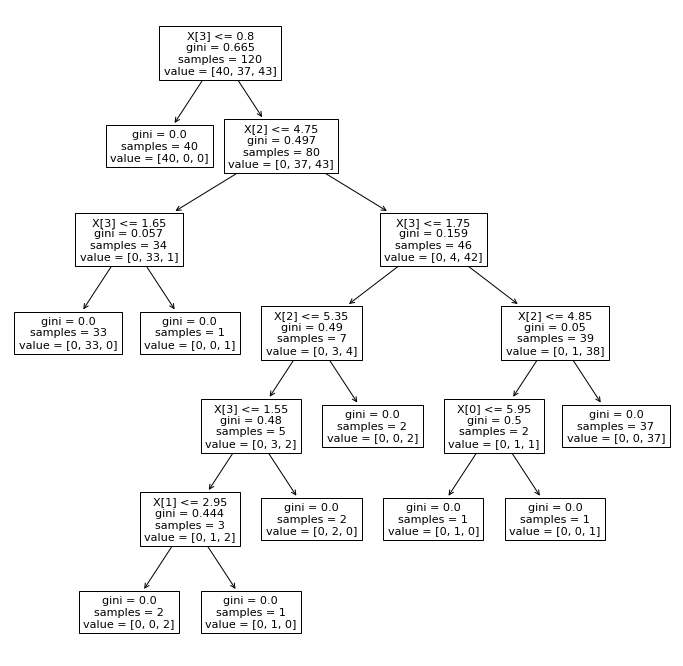

In [84]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(tree_class_model);

Jaké parametry můžeme do kreslící funkce vložit? Nikdo asi nechce luštit, který to vlastně prediktor se skrývá pod X[1] apod. Použijeme tedy parametr **feature_names**, do něhož umístíme list názvů prediktorů. Nastavení parametru **filled** na True pak barevně označí míru zastoupení jednotlivých tříd v uzlech.

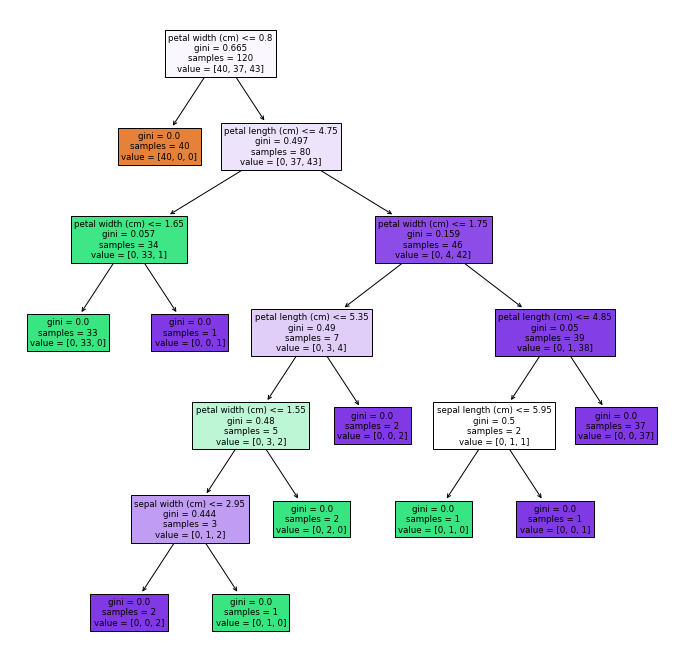

In [85]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(
    tree_class_model,
    feature_names=train_feat_iris.columns,
    filled=True
);

Narozdíl od lineární regrese umožňující pouze řešení regresních úloh a logistické regrese, která dovolovala řešit pouze úlohy  klasifikační, můžeme s pomocí stromu řešit oba typy problémů. Klasifikaci jsme si již ukázali, přejděme tedy na regresi. Pro ti platí prakticky to samé co pro klasifikaci, pouze výsledná hodnota nečistého ulzu se určuje jako průměr hodnot jeho elementů. 

In [86]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2, random_state=10)

tree_regr_model = DecisionTreeRegressor()
tree_regr_params = {
    "min_samples_split":[2,5,8,10,12,15,20,25],
    "min_samples_leaf":[1,2,3,4,5]
}

gridseach_regr_tree = GridSearchCV(tree_regr_model, tree_regr_params)
gridseach_regr_tree.fit(train_feat_boston, train_target_boston)

print(f"Train R2 score: {gridseach_regr_tree.score(train_feat_boston, train_target_boston)}")
print(f"Test R2 score: {gridseach_regr_tree.score(test_feat_boston, test_target_boston)}")

Train R2 score: 0.9580671129418059
Test R2 score: 0.7764627525617774


Pro vykreslení regresního stromu použijeme navíc parametr max_depth, který říká, kolik maximálně pater stromu vykresleno bude. Celý strom by  tomto konkrétním případě dost dobře vidět nebyl.

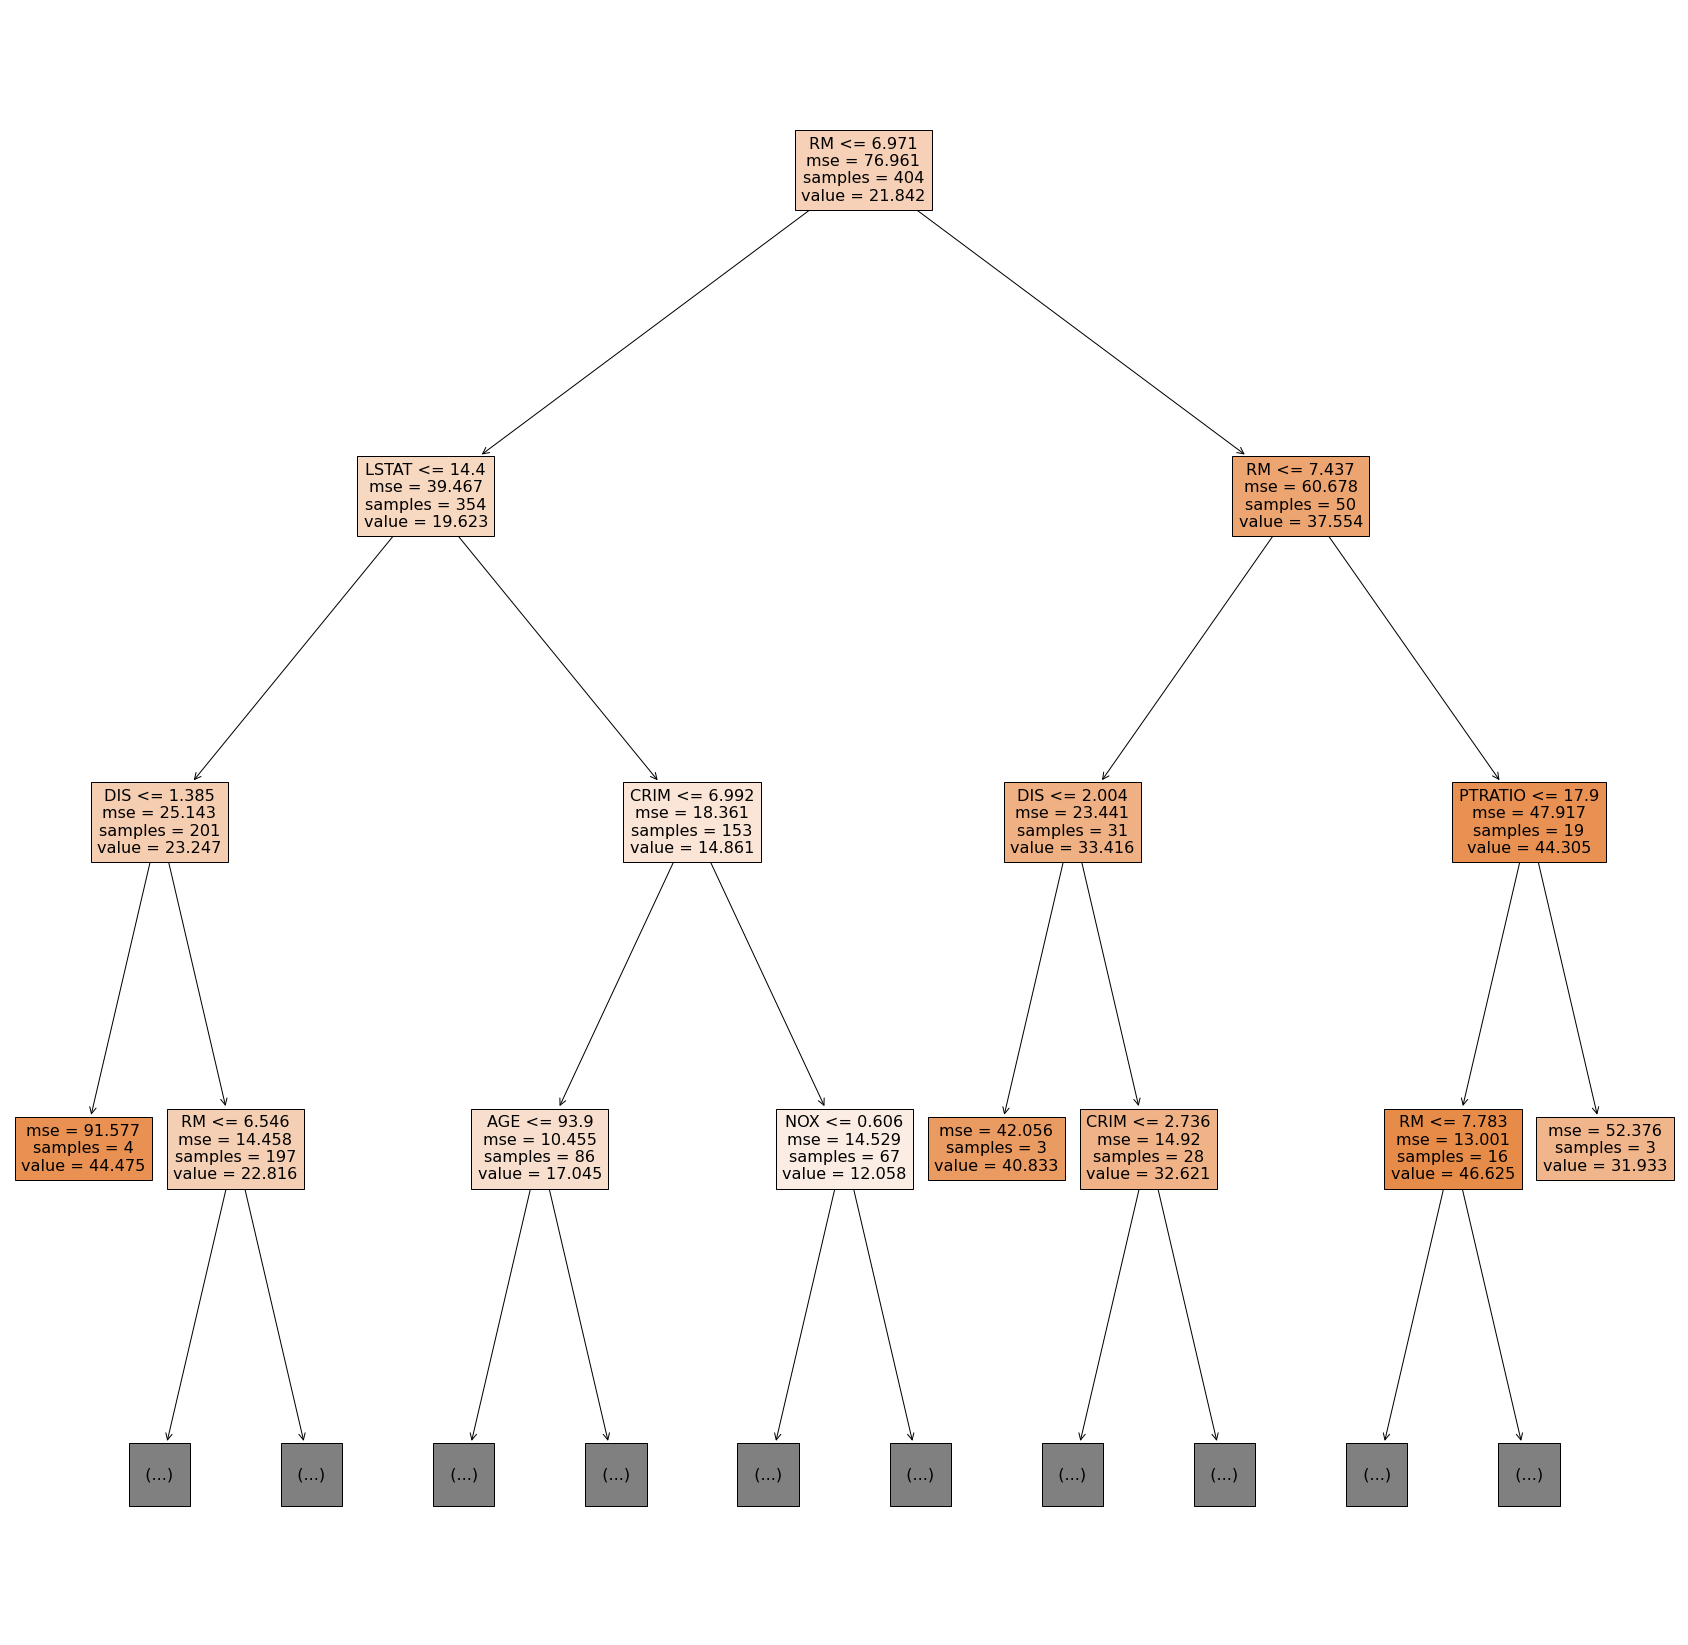

In [87]:
from sklearn import tree

fig, ax = plt.subplots(figsize=(30, 30))
tree.plot_tree(
    gridseach_regr_tree.best_estimator_,
    feature_names=train_feat_boston.columns,
    filled=True,
    max_depth=3
);

## 2.8 Ensemble algoritmy obecně  
Následující dva algoritmy budou patřit do rodiny ensemble algoritmů. Ty se skládají z relativně velkého množství base klasifikátorů/regresorů, které tím či oním způsobem o konečné predikci hlasují. Proč se něco takového vůbec používá? Představme si, že bychom měli ansámbl 25 binárních klasifikátorů, každý mírou chybovosti 0.35. Pokud by byly všechny tyto klasifikátory stejné, ohodnotili by ten který záznaam také totožně a chyba celého ansámblu by tak zůstala na 0.35. Pokud by ale klasifikátory byly nezávislé, tj. jejich chyby by nekorelovaly, pak by ansámbl udělal chybnou predikci jen když by se spletla více než polovina jeho členů. Chyba ansámblu se tedy dá vyjádřit jako  
$error_{ensemble} = \sum_{i=13}^{25}\binom{25}{i}error_{one}^i (1-error_{one})^{25-i} = 0.06$  
Aby by byl ansámbl použitelný, musí platit, že
- base klasifikátory by měly být vzájemně nezávislé (což bývá v praxi obtížné splnit na 100 %)
- base klasifikátory by měl být lepší než náhodné hádání

Jak můžeme obecně ansámbl vytvořit?
- manipulací s trénovacím datasetem - resamplingem původních dat lze vytvořit mnoho trénovacích setů; patří sem věci založené na bagginu a boostingu
- manipulací s prediktory - trénovací množiny jsou podmnožinami všech prediktorů; patří sem např. random forest
- manipulací s učícím algoritmem - mnohé algoritmy lze nastavit tak, aby při opakovaném běhu dávaly různé výsledky, např. neuronová síť při změněné topologii

## 2.9 Random forest
Je založen na tom, že stromy různých tvarů hlasují.Tyto stromy mohou obecně vznikat následně:
- Náhodně se vybere X prediktorů, přičemž při dělení nodů se sledujíc pouze tyto vybrané prediktory. Strom pak roste bez pruningu. Pro malé x jsou stromy méně korelované, avšak síla jednotlivých klasifikátorů je menší.
- Jako předchozí, ale prediktory se množí lineární kombinací prediktorů původních.
- Náhodně se vybere jeden z X nejlepších splitů. Stromy jsou korelované více než u předchozích případů a celý proces trvá déle.

In [88]:
from sklearn.ensemble import RandomForestClassifier

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)

ranforest_class_model = RandomForestClassifier(random_state=10)
ranforest_class_model.fit(train_feat_iris, train_target_iris)

print(f"Train score: {ranforest_class_model.score(train_feat_iris, train_target_iris)}")
print(f"Test score: {ranforest_class_model.score(test_feat_iris, test_target_iris)}")
pd.crosstab(
    ranforest_class_model.predict(test_feat_iris), 
    test_target_iris
)

Train score: 1.0
Test score: 1.0


target   0   1  2
row_0            
0       10   0  0
1        0  13  0
2        0   0  7

Parametry vložitelné do konstruktoru modelu se z velké části překrývají s těmi jdoucími do stromových modelů. Specifikem je stanovení počtu hlasujících - **n_estimators**. Zde větší číslo je lepší, ale o to déle trénování trvá. Pro nevybalancovaná trénovací data lze použít **class_weight="balanced"**.  
Atributy modelu a funkce na něj napojené jsou opět ekvivalentní s těmi, které jsme již viděli u jiných typů modelů. Výjimkou je atribut **feature_importances_ ukazující**, jak byl ten který prediktor pro model důležitý. Tyto důležitosti jsou vypočteny jako (normalizované) celkové snížení nečistot nodů, kterého bylo dosaženo pomocí příslušného prediktoru. Pro prediktory s velkým počtem unikátních hodnot ale tato metrika nebývá nejpřesnější.

In [89]:
ranforest_class_model.feature_importances_

array([0.09730907, 0.02028598, 0.45972955, 0.4226754 ])

Pro větší počet prediktorů by takovýto seznam nebyl moc přehledný a navíc bychom si mohli poplést, které číslo patří ke kterému prediktoru. Naštěstí si tuto informaci lze vykreslit do grafu a to pomocí funkce **plot_feature_importances** z balíčku scikitplot. Parametry je model, jména prediktorů a hodí se stanovit i **x_tick_rotation**, aby jména prediktorů nešla přes sebe. 

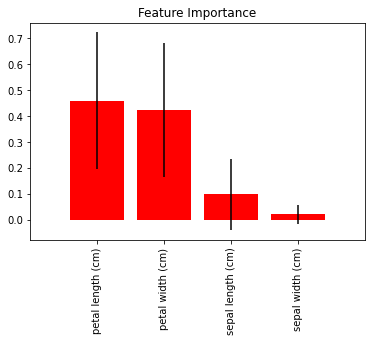

In [90]:
import scikitplot as skplt

skplt.estimators.plot_feature_importances(
    ranforest_class_model,
    feature_names=train_feat_iris.columns,
    x_tick_rotation=90
)

Random forest lze využít i na regresní úlohu:

Train score: 0.9832981317180364
Test score: 0.8790663482232355


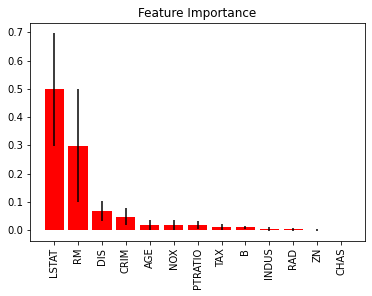

In [91]:
from sklearn.ensemble import RandomForestRegressor

train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2)

ranforest_regr_model = RandomForestRegressor(random_state=10)
ranforest_regr_model.fit(train_feat_boston, train_target_boston)

print(f"Train score: {ranforest_regr_model.score(train_feat_boston, train_target_boston)}")
print(f"Test score: {ranforest_regr_model.score(test_feat_boston, test_target_boston)}")

skplt.estimators.plot_feature_importances(
    ranforest_regr_model,
    feature_names=train_feat_boston.columns,
    x_tick_rotation=90
)

## 2.10 Gradient boosting decision tree  
Boosting algoritmy obecně jsou založeny na iterační proceduře, kdy se člověk novými base klasifikátory snaží správně klasifikovat záznamy, které byly předchozími base klasifikátory oštítkovany špatně. U gradient boosting decision tree konkrétně se postupně přidávají strom po stromu.  
Implementaci GBDT lze nalézt i v scikit learnu (sklearn.ensemble.GradientBoostingClassifier), nicméně více se používá XGBoost. S jeho defaultním rozhraním se sice pracuje trochu jinak než s doposud ukázanými algoritmy, má ale i scikit-learnovský rozhraní:

In [92]:
import xgboost
from sklearn.model_selection import train_test_split

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)

xgboost_class_model = xgboost.XGBClassifier()
xgboost_class_model.fit(train_feat_iris, train_target_iris)

print(f"Train score: {xgboost_class_model.score(train_feat_iris, train_target_iris)}")
print(f"Test score: {xgboost_class_model.score(test_feat_iris, test_target_iris)}")
pd.crosstab(
    xgboost_class_model.predict(test_feat_iris), 
    test_target_iris
)

Train score: 1.0
Test score: 1.0


target   0   1  2
row_0            
0       10   0  0
1        0  13  0
2        0   0  7

Co se týče hyperparametrů modelu, je jich zde více než v u sklearnovském RandomForestu. Vystupuje tu opět počet base klasifikátorů coby **n_estimators**. Podotkněme, že narozdíl od RandomForestu zde automaticky neznamená, že větší číslo by bylo lepší. To trochu souvisí s dalším parametrem - hloubku stromů alias **max_depth**. Zdůrazněme, že v rámci GridSearchCV by se tyto dva parametry neměly stanovovat separátně. Samozřejmě ideální by bylo, kdyby se do GridSearche umístily všechny možné hyperparametry, ale poté by hledání jejich optimálních hodnot zabralo příliš dlouhou dobu. Nicméně pokud by se **max_depth** a **n_estomators** vyhodnotily separátně, měl by člověk u obého velké hodnoty a výsledkem by byl přetrénovaný model.  
Z parametrů ostatních zmiňme regularizační členy **reg_alpha** (L1 regularizace) a **reg_lambda** (L2 regularizace). Dále pak **learning_rate**, číslo mezi nulou a jedničkou, kterým se přenásobují příspěvky nových prediktorů, aby se zabránilo overfitu. Za jeho nižší hodnotu ale člověk zase platí tím, že pro stejný optimální výsledek potřebuje více stromů v lese. Uveďme dále **early_stopping_round**. Pokud nedojde ke zlepšení po počtu iterací rovných **early_stopping_round**, tréning modelu se zastaví. Nakonec zmiňme vypisování hlášek, jak učení postupuje. To se provádí pomocí parametru **verbosity**. Ten přebírá hodnoty 0 až 3, kde 0 znamená žádné hlášky a 3 vše včetně debugovacích zpráv.

I XGBoost lze použít na regresi:

Train score: 0.9999902091332646
Test score: 0.905361478157804


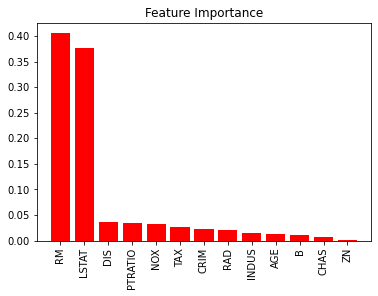

In [93]:
train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2)

xgboost_regr_model = xgboost.XGBRegressor()
xgboost_regr_model.fit(train_feat_boston, train_target_boston)

print(f"Train score: {xgboost_regr_model.score(train_feat_boston, train_target_boston)}")
print(f"Test score: {xgboost_regr_model.score(test_feat_boston, test_target_boston)}")

skplt.estimators.plot_feature_importances(
    xgboost_regr_model,
    feature_names=train_feat_boston.columns,
    x_tick_rotation=90
)

# 3. Interpretovatelnost

Bývá nepříjemné, když musíme na ML model hledět jako na black box, když nevíme, proč se rozhoduje tak, jak se rozhoduje. Již jsme si pověděli, že u lineární regrese s neškálovanými daty říkají naučené koeficienty, o kolik se cílová hodnota změní po zvýšení odpovídajícího prediktoru o jedna. U logistické regrese nám zase koeficienty prozradí, kolikrát se zvýšením prediktoru o jedna zvýší pravděpodobnost třídy pozitivní nad třídou negativní. U většiny dalších algoritmů zase máme tu možnost nechat si vypsat a do grafu vykreslit důležitost prediktorů. Niméně tímto naše možnosti nekončí.  

## 3.1 Partial dependence grafy
Partial dependence grafy ukazují, jak závisí predikovaná hodnota (resp. pravděpodobnost pozitivní třídy v případě klasifikačních úloh) na jednom konkrétním prediktoru, když jsou hodnoty prediktorů ostatních de facto zprůměrované. Povinnými vstupy je model, který chceme zkoumat, jméno studovaného prediktoru a nějaká, obvykle trénovací, data. U nich nepotřebujeme cílové hodnoty, pouze prediktory. Jelikož tedy chceme vykreslit závislost výstupu modelu (osa y grafu) na možných hodnotách jednoho prediktoru (osa x grafu), spočítáme si pro každý možný bod na ose x (i když se třeba v datech nenalézá) aritmetický průměr odezev modelu na data. Zdůrazněme, že ta jsou lehce upravená - hodnoty všech prediktorů krom zkoumaného jsou původní, pro zkoumaný prediktor však dosazujeme právě onen bod na ose x. Tj. přibližně platí  
$PartDepend(x_S) \approx \frac{1}{n}\sum_{i=1}^{n}f(x_S, x_C)$  
Zde $x_S$ je zkoumaný prediktor, $x_C$ představuje všechny ostatní prediktory najednou, n značí počet záznamů a f model.  
Zde už se dají nahlédnout dva problémy s partial dependece grafy spojené. Předpokládá se, že prediktor $x_S$ nekoreluje s prediktory ostatními. Pokud by tomu tak totiž nebylo, mohly by vzniknout nesmyslné kombinace, na které odezvu modelu ani nemá smysl uvažovat. Klasickým příkladem by byly prediktory obsahující výšky a váhy lidí. I když bychom tuto potíž pominuli, stále se nám vykreslí graf pro celou osu x, i když v některých oblastech mnoho reálných dat nemuselo být a tudíž výstup modelu pro ně nemusí být důvěryhodný.  
Pro demonstraci si nejprve vytvořme ten nejjednodušší model - lineární regresi bez škálování a regularizace

In [95]:
from sklearn.linear_model import LinearRegression

lin_reg_model = LinearRegression()
lin_reg_model.fit(boston_dataframe.drop("target", axis=1), boston_dataframe["target"]);

Nyní zavolejme **plot_partial_dependence** funkci, která popořadě přebírá model, data a jména prediktorů k vykreslení (ta musí být v listu, nikoli ve formě stringu).  
Podle očekávání (model byl **lineární** regrese) vidíme lineární závislost. Nad osou x vidíme krátké čáry - ty odpovídají hodnotám zkoumaného prediktoru ve skutečných datech.

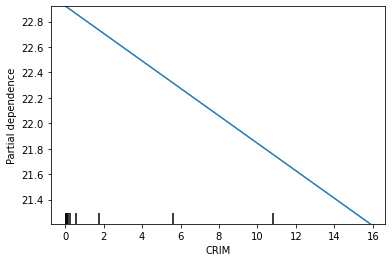

In [96]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(
    lin_reg_model, 
    boston_dataframe.drop("target", axis=1), 
    features=["CRIM"]
);

Nicméně vykreslit si partial dependence pouze pro jeden prediktor by byl příliš malý cíl - proč nevykreslit závislost pro každý z prediktorů? Když tak učiníme, všimneme si dvou věcí. Jednak vykreslení (či přesněji nápočet) vcelku dlouho trvá. Dále pak výsledný produkt nemá optimální velikost. 

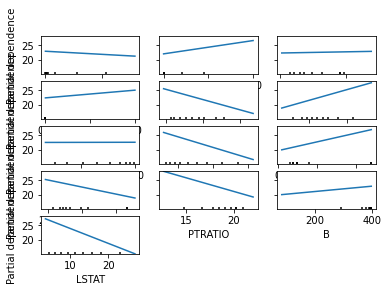

In [97]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(
    lin_reg_model, 
    boston_dataframe.drop("target", axis=1), 
    features=boston_dataframe.drop("target", axis=1).columns
);

S rychlostí asi nic neuděláme, se zobrazením už ale ano:

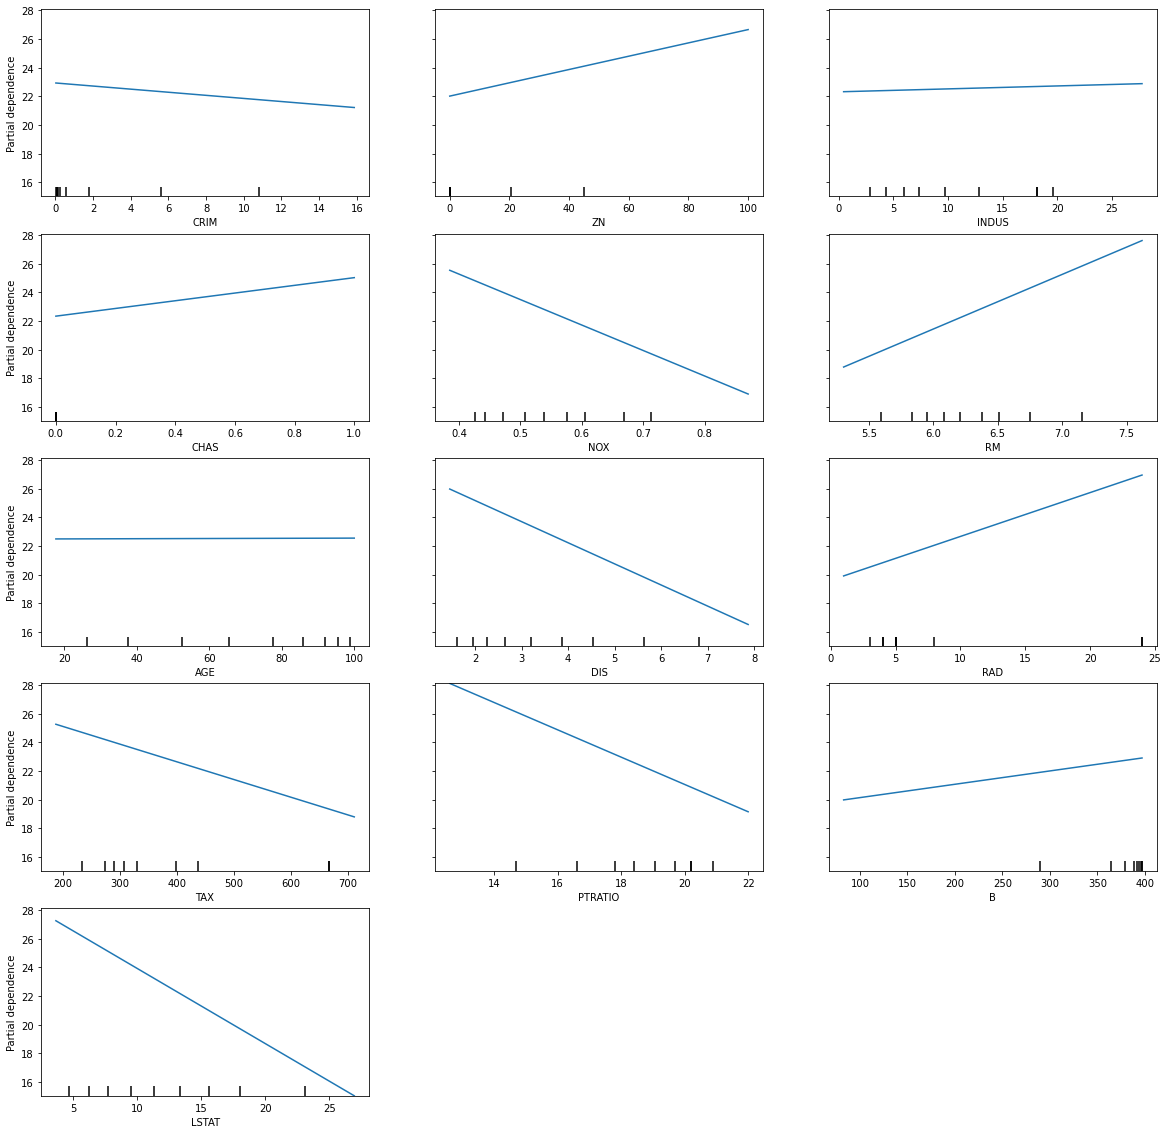

In [98]:
from sklearn.inspection import plot_partial_dependence

width = 20
height = 20
fig, ax = plt.subplots(figsize=(width, height))
plot_partial_dependence(
    lin_reg_model, 
    boston_dataframe.drop("target", axis=1), 
    features=boston_dataframe.drop("target", axis=1).columns,
    ax=ax
);

Výše jsme viděli vykreslení závislost výstupu modelu na jednom prediktoru. Teoreticky by se mohla vykreslit i závislost na více prediktorech současně, více než dva prediktory naráz se ale dost dobře zobrazit nedají. A jak zařídit aspoň to? Do listu se seznamem prediktorů se nezadá název jednoho prediktoru, ale tuple s dvěma prediktory.

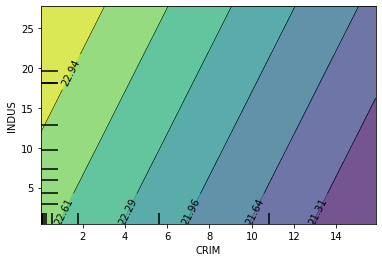

In [99]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(
    lin_reg_model, 
    boston_dataframe.drop("target", axis=1), 
    features=[("CRIM", "INDUS")]
);

## 3.2 LIME  
Zkratka LIME znamená "Local Interpretable Model-agnostic Explanations". Metoda takto označená je založena na tom, že se chování složitého modelu snaží aproximovat modelem lineárním. Jak to provádí? Vezme jeden vstupní záznam (ten, u kterého chceme znát zdůvodnění jeho posouzení modelem) a vytvoří si z něj několikero záznamů pozměněných. U klasických tabulkoidních dat se to realizuje přidáním šumového členu. Následně LIME takto vzniklá data nechá vyhodnotit modelem a zaznamená si odpovídající výstupy. Vstupy a výstupy následně použije k vytvoření interpretovatelného lineárního modelu říkajícího, jak ten který prediktor mohl onen jeden původní záznam ovlivnit. LIME tak vysvětluje ne celý model, ale jeho lokální odezvu na jeden konkrétní záznam.  
S tím, jak LIME funguje, se pojí i určité nevýhody. Například je poněkud problematický u one-hot encodovaných prediktorů - ty obsahují jen a pouze hodnoty 0 a 1, zatímco LIME si pro svůj lineární model vytvoří hodnoty třeba 0.995 a 1.005, které fakticky původní model nikdy na vstupu nemá.  
Implementaci LIME v Pythonu lze použít i na text či obrázky, zde si ale ukážeme, jak funguje pro klasická tabulkoidní data. Vyrobme si napřed model - logistickou regresi.

In [100]:
from sklearn.linear_model import LogisticRegression

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)
    
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_feat_iris, train_target_iris)

LogisticRegression(max_iter=1000)

V rámci LIME se nejprve musí vytvořit explainer objekt. Ten jako první parametr bere trénovací data. Proč, když se výše psalo, že si LIME vystačí s jediným vstupním bodem? Na trénovacích datech se spočítají statisitky - průměr a standardní odchylka pro numerická data, frekvence pro kategorická data. S pomocí těchto statistik se pak šumová data rozumně naškálují.  
Z hlediska praktického by raději neměla mít tato trénovací data podobu dataframu - mohlo by to skončit chybovou hláškou "TypeError: '(slice(None, None, None), 0)' is an invalid key" (stalo se mi to u boston datasetu, ale nikoli u irisového datasetu). Podle [dokumentace](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular) se zde očekává numpy array, takže není nic jednoduššího než na dataframu zavolat metodu **to_numpy**.  
Velice užitečným parametrem je **feature_names**. V něm by měly být jména sloupců z trénovacích dat. Pokud by absentoval, budou u vysvětlení rolí jednotlivých prediktorů-sloupců tyto sloupce označeny svým indexem a nikoli jménem.  
Parametr **discretize_continuous** říká, zda mají být numerické prediktory diskretizovány. Praktický důsledek je takový, že v případě False nebudou v jednom z pozdějších grafů vypsána pravidla, proč přesně daný prediktor přispěl k tomu či onomu výsledku. Jinými slovy, je lepší tento parametr nechat na defaultním True.  
Parametr **mode** LIME sděluje, zda je úloha, kterou zkoumá, klasifikační či regresní (hodnoty **"classification"** a **"regression"**) - defaultní hodnota je **"classification"**. 
Parametr **class_names** je na tom podobně jako **feature_names**. Neuvedeme-li ho, budou třídy označeny svým pořadovým číslem.   
Parametr **categorical_features** dovoluje explicitně specifikovat kategorické prediktory. Ty musí obsahovat jen a pouze celá čísla, nikoli textové řetězce. Všechny ostatní prediktory musí být spojité. 

In [101]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    train_feat_iris.to_numpy(), 
    feature_names=train_feat_iris.columns, 
    class_names=["iris setosa", "iris versicolor", "iris verginica"]
)

Pro vysvětlení, proč se model rozhodl určitý záznam klasifikovat tak, jak se rozhodl, použijeme metodu explaineru **explain_instance**. Ta jako první argument přebírá 1D numpy array s oním zkoumaným záznamem. Následuje predikční funkce. Tou je u regresních úloh klasická **predict**. U úloh klasifikačních se musí jednat o predikční funkci poskytující pravděpodobnost, nikoli třídu, tj. je potřeba **predict_proba**. Lze specifikovat i maximální počet prediktorů, který se ve vysvětlení objeví - k tomu použijeme atribut **num_features**. Velice důležitým parametrem pro multiclass problémy je **top_labels**. Pokud bychom ho neuvedli, objevil by se srovnávací graf (viz níže) jen pro jednu třídu. Po zadání **top_labels=N** se objeví graf pro N tříd.

In [102]:
exp = explainer.explain_instance(test_feat_iris.iloc[0], log_reg_model.predict_proba, top_labels=5)

K tomu, abychom si zobrazili grafy LIME, použijeme metodu **show_in_notebook**. Úplně nalevo vidíme původním ML modelem určené pravděpodobnosti zařazení záznamu do jednotlivých tříd. Úplně napravo jsou ukázány parametry záznamu s tím, že barevný podkres určuje, ke které třídě by hodnota toho kterého prediktoru záznam vedla. Grafy uprostřed jsou (pro jednotlivé třídy) seřazeny od nejdůležitějšího prediktoru k tomu nejméně důležitému. Velikost barevného obdelníku odpovídá tomu, jak moc příslušná hodnota (nebo spíše příslušný vztah hodnotu obsahující) přispívá k (ne)členství v dané třídě.

In [103]:
exp.show_in_notebook()

Vztahy hodnoty obsahující jsou občas příliš velké a nejsou tudíž v grafech celé vidět. Naštěstí si je můžeme vypsat s pomocí metody **as_list**. Zde parametr **label** určuje index třídy, pro kterou chceme parametry (a jejich míru dopadu) znát.

In [104]:
exp.as_list(label=0)

[('4.35 < petal length (cm) <= 5.10', -0.40462223051358054),
 ('sepal width (cm) <= 2.80', -0.0399042179159128),
 ('5.80 < sepal length (cm) <= 6.50', -0.023494968225077968),
 ('0.30 < petal width (cm) <= 1.30', -0.0033896204947987587)]

In [105]:
exp.as_list(label=1)

[('4.35 < petal length (cm) <= 5.10', 0.30729867122666765),
 ('0.30 < petal width (cm) <= 1.30', 0.08132289342533981),
 ('5.80 < sepal length (cm) <= 6.50', 0.04344620318472291),
 ('sepal width (cm) <= 2.80', 0.029244355727617903)]

In [106]:
exp.as_list(label=2)

[('4.35 < petal length (cm) <= 5.10', 0.09732355928691284),
 ('0.30 < petal width (cm) <= 1.30', -0.07793327293054106),
 ('5.80 < sepal length (cm) <= 6.50', -0.019951234959644924),
 ('sepal width (cm) <= 2.80', 0.010659862188294929)]

Kooperace sklearnu a LIME je vcelku bezproblémová. U použití LIME s XGBoostem ale existuje pár problematických bodů.  
Nejprve proveďme rozdělení vstupních dat na trénovací a testovací.

In [107]:
import xgboost
from sklearn.model_selection import train_test_split

train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2, random_state=10)

xgboost_regr_model = xgboost.XGBRegressor(random_state=10)
xgboost_regr_model.fit(train_feat_boston, train_target_boston)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

V konstruktoru explaineru musíme explicitně napsat, že chceme provádět regresi. Podstatnější změna je ale v parametrech metody **explain_instance**. Pokud člověk nechce koukat na hromadu chybových hlášek, musí zde být provedeno přetrénování modelu, tj. nestačí sem napsat referenci na již natrénovaný model. Dále pak je třeba trénovací data převést z dataframů na numpy arraye.

In [108]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    train_feat_boston.to_numpy(), 
    feature_names=train_feat_boston.columns, 
    discretize_continuous=True,
    mode="regression"
)

exp = explainer.explain_instance(
    test_feat_boston.iloc[0], 
    xgboost_regr_model.fit(train_feat_boston.to_numpy(), train_target_boston.to_numpy()).predict
)

exp.show_in_notebook()

## 3.3 SHAP

Zkratka SHAP značí **SH**apley **A**dditive ex**P**lanation. Popravdě dost dobře nerozumím, jak že to vlastně funguje. Na následujících řádcích se sice pokusím shrnout svoje dojmy, laskavý čtenář ale asi udělá lépe, když nahlédne [sem](https://arxiv.org/pdf/1705.07874.pdf), [sem](https://www.rand.org/content/dam/rand/pubs/research_memoranda/2008/RM670.pdf) či [sem](https://arxiv.org/pdf/2010.13972.pdf).  
Takže... SHAP vytváří u každé predikce určitého záznamu pro každý prediktor určitou hodnotu jeho důležitosti. De facto zde vzniká model g pro vysvětlení predikce, který lze definovat jako  
$g(z´) = \phi_0 + \sum_{i=1}^M\phi_iz_i´$  
Zde M je počet prediktorů, $z_i´$ indikuje přítomnost i-tého prediktoru a $\phi_i$ značí relativní příspěvek tohoto prediktoru k modelu g(z´) vysvětlujícího chování modelu f(x) na záznamu x. O oněch $\phi_i$ se mluví jako o Shapleyho hodnotách. Spočítat je lze s pomocí lehce divokého vzorečku, který se tu snad ani neodvážím uvést. Principielně v něm ale jde (aspoň pokud jsem ho dobře pochopil) o vliv i-tého prediktoru na odezvu původního modelu f(x), když se onen i-tý prediktor přidá k už utvořené množině prediktorů. Celé je to navíc iterativní proces, tj. na začátku není prediktor žádný. Samozřejmě takhle vyvstává otázka, co to vlastně znamená přidání/odebrání/absence prediktoru v modelu. Asi se bere průměr všech trénovacích dat v modelu bez ohledu na hodnotu i-tého prediktoru (s tím, že ona data už ale musí splňovat podmínky na prediktory z původní skupiny prediktorů).  
Ať už uvnitř SHAPu tiká co chce a jak chce, jedná se na zdroje poměrně agresivní algoritmus (exponenciální složitost). Tvůrci balíčku shap (a autoři jednoho z těch článků zmíněných výše) ale přišli na to, že po splnění určitých předpokladů se dá pro konkrétní rodiny ML algoritmů SHAP učinit *pouze* polynomiálně složitým. Většina těchto rodin spadá do deep learningu, ale jedna se týká i lesů.  
Vytvořme si napřed xgboost model.

In [109]:
import xgboost
from sklearn.model_selection import train_test_split

train_feat_boston, test_feat_boston, train_target_boston, test_target_boston = \
    train_test_split(boston_dataframe.drop("target", axis=1), boston_dataframe["target"], test_size=0.2, random_state=10)

xgboost_regr_model = xgboost.XGBRegressor(random_state=10)
xgboost_regr_model.fit(train_feat_boston, train_target_boston);

Pro samotné praktické použití se zavolá funkce **initjs**, inicializující prostředí k zobrazení grafů. Následně se vytvoří instance TreeExplaineru, které se předá natrénovaný model. Na tomto objektu je potom provolána jeho metoda **shap_values**, která jako vstup bere data, která chceme vysvětlit, a která vyrábí SHAP hodnoty.

In [110]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgboost_regr_model)
shap_values = explainer.shap_values(test_feat_boston)

Chceme-li vysvětlit predikci pro jeden záznam, použijeme **force_plot**. Tato funkce jako svůj první parametr přebírá base_value neboli referenční hodnotu cílového sloupce, když nejsou použity žádné prediktory. Tuto hodnotu lze získat z Tree_Explainer instance **explainer** jako **explainer.expected_value**. Dalším parametrem je (pro jeden záznam) jednorozněrné numpy array se SHAP hodnotami pro každý prediktor. Následuje parametr **features**, který obsahuje hodnoty prediktorů pro daný záznam.  
Na výsledném obrázku vidíme slabě šedým fontem vyznačenou base value. Fialovou barvou jsou vyznačeny prediktory tlačící predikci k vyšším číslů,m, modrá barva pak patří k prediktorů stalčující predikci dolů. Čísla vedle jmen prediktorů jsou jejich hodnotami pro daný záznam. Velikost plochy patřící tomu či onomu prediktoru má význam příspěvku prediktoru k výsledku. Nakonec tučně je vyznačena predikce.

In [111]:
shap.force_plot(explainer.expected_value, shap_values[0,:], train_feat_boston.iloc[0,:])

Pokud bychom do **force_plot** nevložili jeden záznam (a tedy shap_values a train_feat_boston by nebyly 1D pole), ale všechny záznamy, bude graf mnohem komplexnější. Všimněte si, že lze měnit význam jak osy x, tak osy y.

In [112]:
shap.force_plot(explainer.expected_value, shap_values[:,:], train_feat_boston.iloc[:,:])

Graf přehledně shrnující chování modelu vykreslíme pomocí **summary_plot**. Zde každý bod odpovídá SHAP hodnotě jednomu záznamu a prediktoru. Pokud mělo u daného prediktoru stejnou SHAP hodnotu více záznamů, jsou body vůči sobě z hlediska y-ové osy lehce posunuty. Barevně je navíc vyznačeno, zda byla u daného záznamu hodnota prediktoru větší nebo menší než průměr. Například u prediktoru RM (počet místností) pozorujeme, že záznamy s velkou hodnotou RM získali pro tento prediktor velkou kladnou SHAP value, což vedlo k navýšení hodnoty cílové veličiny. Naopak záznamy s relativně maliou hodnotou RM obdržely relativně malou zápornou SHAP hodnotu a tudíž se u nich kvůli malému RM cílová veličina zmenšila. Z hruškového tvaru shluku bodů také vidíme, že takovýchto záznamů bylo relativně hodně.

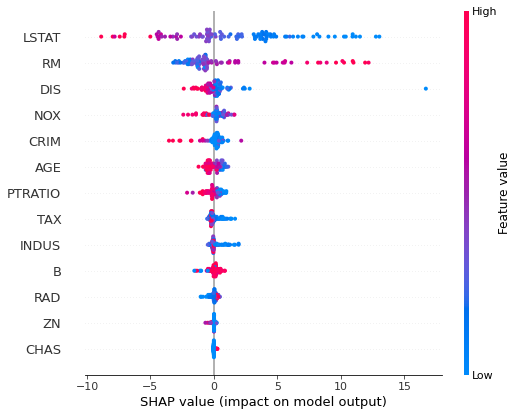

In [113]:
shap.summary_plot(shap_values, test_feat_boston)

Pro algoritmy nezaložené na stromech lze využít KernelExplainer. Jeho nápočet ale pro modely komplexnější, než je ten, který níže ukazuji, trvá dosti dlouho. Pozn.: pokud Vám následující kód padá pvůli absenci jakéhosi IPanelu, musíme si pro Jupyter nainstalovat a zprovoznit widgety.

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2, random_state=10)
    
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(train_feat_iris, train_target_iris)

LogisticRegression(max_iter=1000)

Oproti předchozí situaci potřebuje explainer nejen model, ale i trénovací data.

In [115]:
import shap

shap.initjs()
explainer = shap.KernelExplainer(log_reg_model.predict_proba, train_feat_iris)
shap_values = explainer.shap_values(test_feat_iris)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Máme úlohu, kde cílová hodnota může odpovídat třem třídám. Tudíž pro jeden záznam lze sestrojit tři grafy odpovídající té které třídě.

In [116]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_feat_iris.iloc[0,:])

In [117]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], test_feat_iris.iloc[0,:])

In [118]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], test_feat_iris.iloc[0,:])

I shrnující graf vypadá kvůli typu úlohy lehce jinak.

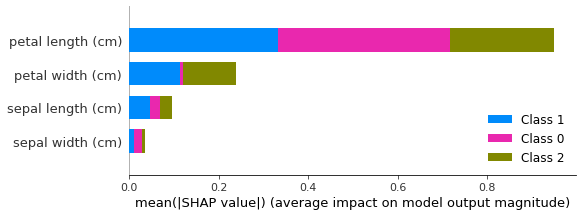

In [119]:
shap.summary_plot(shap_values, test_feat_iris)

# 4. Uložení modelů a pipeliny  
## 4.1 Ukládání
Dejme tomu, že jsme natrénovali model. Nyní bychom ho chtěli začít používat. Ihned narazíme na jeden závažný problém. Natrénovaný model nám momentálně sídlí v paměti a jakmile jupyteří notebook vypneme, bude patřit minulosti. Musíme tudíž najít způsob, jak ML model uložit.  
Asi nejpřímočařejší řešení této úlohy je použití interního pythoního balíčku **pickle**. S pomocí jeho funkce **dump** můžeme ML model uložit do binárního souboru, ze kterého ho posléze s pomocí funkce **load** zase nahrajeme.  
Nejprve si vytvořme model:

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

scaler_iris_minmax = MinMaxScaler()
scal_feat_iris = pd.DataFrame(
    scaler_iris_minmax.fit_transform(iris_dataframe.drop("target", axis=1)),
    columns=iris_dataframe.drop("target", axis=1).columns
)

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(scal_feat_iris, iris_dataframe["target"])

LogisticRegression(max_iter=1000)

Nyní model uložíme do souboru:

In [121]:
import pickle
with open("pickle_model.pkl", "wb") as model_file:
    pickle.dump(log_reg_model, model_file)

A ze souboru ho zase nahrajeme:

In [122]:
with open("pickle_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)
loaded_model

LogisticRegression(max_iter=1000)

... a aplikujeme na nový záznam (ta dvojka na výstupu značí třídu 2):

In [123]:
test_record = np.array([[0.222222, 0.625000, 0.067797, 0.99999]])
loaded_model.predict(test_record)

array([2])

Alternativním způsobem pro ukládání modelů je balíček **joblib**. Ten by měl být efektivnější při ukládání a nahrávání objemnějších věcí, např. numpy polí. V našem případě, kdy ukládáme malý model, se moc od picklu lišit nebude.

In [125]:
import joblib
with open("joblib_model.z", "wb") as model_file:
    joblib.dump(log_reg_model, model_file)

In [126]:
with open("joblib_model.z", "rb") as model_file:
    loaded_model = joblib.load(model_file)
loaded_model

LogisticRegression(max_iter=1000)

Nevýhoda výše uvedeného přístupu je v tom, že uložené modely mohou být opět otevřeny pouze Pythonem (a to raději v té samé verzi pythonu, v jaké byly uloženy) a scikit-learnem. Toto omezení lze obejít, když model uložíme ve formátu ONNX (Open Neural Network Exchange Format). I pro jeho nejzákladnější použití musíme nainstalovat rovnou dva balíčky - **skl2onnx** a **onnxruntime**.     
Realizace model ukládací operace je tedy složitější než v případě picklu. Sklearnovský model totiž musíme zkonvertovat na onyxí model a to s pomocí funkce **convert_sklearn**. Ta kromě samotnho modelu přebírá i určité informace o prediktorech. My zde sdělujeme, že prediktory budou čtyři a že jejich typ bude float.

In [127]:
import skl2onnx

number_of_features = 4
initial_type = [
    ('float_input', skl2onnx.common.data_types.FloatTensorType([None, number_of_features]))
]
onx = skl2onnx.convert_sklearn(log_reg_model, initial_types=initial_type)
with open("onyx_model.onnx", "wb") as model_file:
    model_file.write(onx.SerializeToString())

Načtení a použití modelu vypadá následovně:

In [128]:
import onnxruntime

test_record = np.array([[0.222222, 0.625000, 0.067797, 0.99999]])

session = onnxruntime.InferenceSession("onyx_model.onnx")
input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name
pred_onx = session.run([label_name], {input_name: test_record.astype(np.float32)})[0]
print(pred_onx)

[2]


Víc informací ale čtenář nalezne ve vedlejším notebooku **onnx**.

## 4.2 Pipeliny  
Máme tedy vyřešenou otázku uložení modelu. Mohli bychom ale nyní nějaký pickle soubor dejme tomu s logistickou regresí poslat na produkci? Zamysleme se, co by to znamenalo. Samozřejmostí je to, že bychom museli vyrobit kód, který zapicklovaný objekt převede do normálního stavu. Nicméně též musíme převést data, která do modelu chceme posílat na predikci, do stejného formátu, jaký měla data použitá na trénování modelu. Na první pohled to vypadá pouze jako drobná komplikace, situace je ale složitější. V rámci přípravy dat může kupříkladu docházet ke škálování dat. Toto škálování sice můžeme provádět i později, musíme při tom ale znát škálovací parametry. Nebylo by totiž korektní škálovat s parametry predikční sady dat, nemluvě o situaci, kdy by to ani nebylo možné (např. on-line predikce, kdy na model v jeden čas letí třeba jen jeden záznam).  
Řešením popsané lapálie je použití pipelin. De facto se jedná o sérii operací zahrnující jak přípravu dat, tak ML model. Tato série je pak uložitelná podobně jako model. Navíc v sobě už obsahuje i informace o tom, co se s daty děje před nástupem modelu, tj. např. si pamatuje škálovací parametry trénovací sady dat.  
Vytvořme si napřed jednoduchou pipelinu pro klasifikaci kosatcových dat. Co bychom v ní chtěli? Jako první by v ní muselo být nějaké udělátko, které na místo chybějících záznamů vkládalo nějakou rozumnou hodnotu - SimpleImputer. Následně budeme chtít data našklálovat - dejme tomu s MinMaxScalerem. No a nakonec by měl přijít model. Všechny tyto věci vložíme ve správném pořadí do funkce make_pipeline. S vytvořenou pipelinou se dá víceméně zacházet jako s ML modelem - lze na ní provolávat metody **fit**, **predict**, **predict_proba** či **score**.

In [129]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

final_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler(),
    LogisticRegression(max_iter=1000)
)

train_feat_iris, test_feat_iris, train_target_iris, test_target_iris = \
    train_test_split(iris_dataframe.drop("target", axis=1), iris_dataframe["target"], test_size=0.2)

final_pipeline.fit(train_feat_iris, train_target_iris)

final_pipeline.score(test_feat_iris, test_target_iris)

0.9666666666666667

Nicméně vidíme, že složky, ze kterých byla pipelina vytvořena, nikam nezmizely.

In [130]:
final_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

K jednotlivým součástkám můžeme přistupovat pomocí **named_steps**. V příkladu níže se koukáme na atribut **data_min_** (ukazuje minimum všech sloupců) MinMaxScaleru. 

In [131]:
final_pipeline.named_steps["minmaxscaler"].data_min_

array([4.4, 2.2, 1. , 0.1])

Díky tomu můžeme pipelinu uložit do picklu a později zase načíst. Naučené parametry např. scalerů jsou součástí pipeliny a tudíž je pipelina při provolání metody **predict** a spol. použije k transformování dat určených na predikci.  
Pakliže bychom potřebovali aplikovat na všechny sloupce v pipelině nějakou funkci, využijeme **FunctionTransformer**. Tomu bychom předali v parametru **func** jméno oné funkce.  
V případě, že používáme balíček imbalanced-learn, nelze používat scikit-learnovské pipeliny. Naštěstí v imbalanced-learnu jsou vytvořené obdobné funkce a objekty (např. **make_pipeline**), s nimiž se pracuje úplně stejně jako s těmi scikit-lernovskými.  
Bude se stávat, že bude třeba na různé sloupce vypustit různé operace a až produkty těchto operací se sloučí ve finální pipelině vedoucí do modelu. Na to použijeme **ColumnTransformer**. Do toho se jako první parametr sype list tuplů. Ty obsahují tři elemety - jméno transformeru, transformer a list sloupců do transformeru poslaných. Co že to vlastně transformer je? Jedná se o objekt, na který je navázána metoda **transform**. Fakticky jde tedy o cokoli v pipelině kromě ML modelu, resp. o pipelinu tvořenou takovými objekty. ColumnTransformeru můžeme krom listu tuplů zadat i parametr **remainder**, který říká, co se má stát se sloupci, které nejsou zmíněny v tuplech. Defaultní je jejich vyřazení z modelu (explicitně **remainder="drop"**), lze je ale i poslat dál (**"passthrough"**)  
Ve výsledku tak výsledná struktura můře vypadat třeba takto:
```python
from imblearn.pipeline import make_pipeline as make_ibmpipeline

one_hot_pipeline = make_ibmpipeline(
    SimpleImputer(strategy="constant", fillValue="NotPresent"),
    OneHotEncoder(handle_unknown="ignore")
)
scaler_pipeline = make_ibmpipeline(
    SimpleImuter(strategy="constant", fill_value=0),
    FunctionTransormer(func=np.log1p),
    RobustScaler()
)
scaler_nolog_pipeline = make_ibmpipeline(
    SimpleImuter(strategy="constant", fill_value=0),
    RobustScaler()
)
no_change_pipeline = make_ibmpipeline(
    SimpleImuter(strategy="constant", fill_value=0),    
)

joined_pipeline = ColumnTransformer(
    [
        ("scaler", scaler_pipeline, ["column1", "column2"]),
        ("scaler_nolog", scaler_nolog_pipeline, "column3"),
        ("one_hot", one_hot_pipeline, ["column4", "column5"]),
        ("no_change", no_change_pipeline, ["column6", "column7"]),
    ],
    remainder="drop"
)

final_pipeline = make_ibmpipeline(
    joined_pipeline,
    RandomOverSampler(),
    GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
)

final_pipeline.fit(x_train, y_train)
```